# Phase 0: Setup

## Step 1: Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from scipy.stats import norm, chi2_contingency, spearmanr
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    matthews_corrcoef,
    make_scorer,
    f1_score,
    ConfusionMatrixDisplay,
    auc
)
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
import shap

from catboost import CatBoostClassifier, Pool
import catboost.utils

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline

import optuna

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate

import joblib
from functools import partial
import os
import time

## Step 2: Data Loading

In [46]:
unclean_test = pd.read_csv('test.csv')
unclean_train = pd.read_csv('train.csv')

# Phase 1: Exploratory & Statistical Testing

## 1.1: Exploratory Data Analysis
Shape of the data, cleaning the data, monovariate charts, bivariate significance, Mann-WHitney U, Correlation heat-map

### Data Description
Samples (rows): 800
Features (cols): 22

Feature Descriptions:

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `ID`                | Unique identifier for each patient                                          |
| `A1_Score` - `A10_Score` | Scores (0 or 1) for each of the 10 AQ screening questions                  |
| `age`               | Age of the patient (in years)                                               |
| `gender`            | Gender of the patient (`m` or `f`)                                          |
| `ethnicity`         | Ethnicity of the patient (12 unique values, e.g., `White-European`)         |
| `jaundice`          | Whether the patient had jaundice at birth (`yes`/`no`)                      |
| `austim`            | Whether an immediate family member has been diagnosed with autism (`yes`/`no`) |
| `contry_of_res`     | Country of residence (56 unique values)                                     |
| `used_app_before`   | Whether the patient has used a screening app before (`yes`/`no`)            |
| `result`            | Composite score for AQ1-10 screening test (float, can be negative)          |
| `age_desc`          | Age description (all values: `18 and more`)                                 |
| `relation`          | Relation of the person completing the test (6 unique values, mostly `Self`)  |
| `Class/ASD`         | Target variable: 0 (No ASD), 1 (ASD)                                        |

In [47]:
unclean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

All of our variables are not null, so we don't need to worry about that

In [48]:
unclean_train.describe()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.0000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,28.452118,8.537303,0.201250
std,231.0844,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.310966,4.807676,0.401185
min,1.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.718550,-6.137748,0.000000
25%,200.7500,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.198153,5.306575,0.000000
50%,400.5000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.848350,9.605299,0.000000
75%,600.2500,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.865429,12.514484,0.000000
max,800.0000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.461718,15.853126,1.000000


This gives us some quick stats on each of our numerical features.

Below are the numeric columns separated from the rest of the dataset.

In [49]:
unclean_train.iloc[:,[unclean_train[x].dtype != 'object' for x in unclean_train]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         800 non-null    int64  
 1   A1_Score   800 non-null    int64  
 2   A2_Score   800 non-null    int64  
 3   A3_Score   800 non-null    int64  
 4   A4_Score   800 non-null    int64  
 5   A5_Score   800 non-null    int64  
 6   A6_Score   800 non-null    int64  
 7   A7_Score   800 non-null    int64  
 8   A8_Score   800 non-null    int64  
 9   A9_Score   800 non-null    int64  
 10  A10_Score  800 non-null    int64  
 11  age        800 non-null    float64
 12  result     800 non-null    float64
 13  Class/ASD  800 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 87.6 KB


In [50]:
# Create numerical cols list
num_cols = [unclean_train[x].dtype != 'object' for x in unclean_train]

Do the same for categorical features

In [51]:
unclean_train.iloc[:,[unclean_train[x].dtype == 'object' for x in unclean_train]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           800 non-null    object
 1   ethnicity        800 non-null    object
 2   jaundice         800 non-null    object
 3   austim           800 non-null    object
 4   contry_of_res    800 non-null    object
 5   used_app_before  800 non-null    object
 6   age_desc         800 non-null    object
 7   relation         800 non-null    object
dtypes: object(8)
memory usage: 50.1+ KB


In [52]:
# Create categorical cols list
cat_cols = [unclean_train[x].dtype == 'object' for x in unclean_train]

Diving a bit deeper into the categorical features, we want to see the unique values in those columns.

In [53]:
for item in unclean_train.iloc[:,cat_cols]:   
    print(item)
    print(unclean_test[item].unique(), end="\n")
 

gender
['m' 'f']
ethnicity
['White-European' 'Asian' '?' 'Middle Eastern ' 'South Asian' 'Pasifika'
 'Turkish' 'Latino' 'Black' 'Others' 'Hispanic']
jaundice
['yes' 'no']
austim
['no' 'yes']
contry_of_res
['India' 'Mexico' 'Egypt' 'Italy' 'Australia' 'United States' 'Jordan'
 'Burundi' 'United Kingdom' 'Canada' 'Germany' 'Russia' 'Spain' 'Austria'
 'Iran' 'New Zealand' 'Bolivia' 'United Arab Emirates' 'Uruguay' 'Lebanon'
 'France' 'Netherlands' 'Bahamas' 'Iceland' 'Sri Lanka' 'Afghanistan'
 'Pakistan' 'Malaysia' 'Aruba' 'Ireland' 'Viet Nam' 'Tonga' 'Philippines'
 'Azerbaijan' 'Czech Republic']
used_app_before
['no' 'yes']
age_desc
['18 and more']
relation
['Self' 'Parent' '?' 'Relative' 'Others' 'Health care professional']


Inspecting our data, we determine that we can convert the `gender`, `austim`, `jaundice`, and `used_app_before` features into numerical values. `age_desc` can be discarded, as it only contains a single value.

Let's also check if the categories of traning data are consistent with the test data or not. If they aren't we'll face issues  during training and prediction.

In [54]:
for item in unclean_train.iloc[:,cat_cols]:
    print(item)
    print([x for x in unclean_test[item].unique() if x not in unclean_train[item].unique()],end = "\n")

gender
[]
ethnicity
[]
jaundice
[]
austim
[]
contry_of_res
['Uruguay', 'Lebanon', 'Philippines']
used_app_before
[]
age_desc
[]
relation
[]


We can see that the countries `Uruguay`, `Lebanon`, and `Philippines` are present in the test set but not the training set. This will cause problems, so we'll have to deal with it in the data preparation step.

### Cleaning the Data

**Reasoning**:
- Remove the 'age_desc': All samples have the same entry for this feature, so we can disregard it 
- Remove the 'ID': This is an arbitrary value that has no impact on our dataset
- Changed '?' to 'Unknown': Better readability of the data

In [55]:
train = unclean_train.copy()
test = unclean_test.copy()

# Replace '?' with 'Unknown' in both train and test dataframes
train.replace('?', 'Unknown', inplace=True)
test.replace('?', 'Unknown', inplace=True)

# Remove the 'age_desc' column.
train.drop('age_desc', axis=1, inplace=True)

# Remove the 'id' column
train.drop('ID', axis=1, inplace=True)

# Check for remaining missing values.
print("\nMissing Values after cleaning:\n", train.isnull().sum())

# Verify the cleaning steps.
display(train.head())
print(train.shape)


Missing Values after cleaning:
 A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
austim             0
contry_of_res      0
used_app_before    0
result             0
relation           0
Class/ASD          0
dtype: int64


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.172746,f,Unknown,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47.750517,m,Unknown,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23.561927,f,Unknown,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43.205790,m,Unknown,no,no,South Africa,no,-4.777286,Self,0


(800, 20)


### Univariate Plots

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_bar(ax, df, column_name, hue_column='Class/ASD', top_n=15, figsize=None):
    """
    Stacked bar plot for categorical column frequencies by target variable.
    Improved for better readability with adjusted title padding.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    # Get top categories
    top_categories = df[column_name].value_counts(dropna=False).nlargest(top_n).index
    
    # Create a crosstab (contingency table) for the column and class
    crosstab = pd.crosstab(
        df[column_name], 
        df[hue_column],
        dropna=False
    ).loc[top_categories]
    
    # Rename the columns to be more descriptive
    crosstab.columns = ['Non-ASD', 'ASD']
    
    # Replace NaN index with 'NaN' string if it exists
    if any(pd.isna(idx) for idx in crosstab.index):
        crosstab.index = [str(idx) if not pd.isna(idx) else 'NaN' for idx in crosstab.index]
    
    # Create stacked bar chart
    crosstab.plot(kind='bar', stacked=True, ax=ax)
    
    if len(top_categories) > top_n:
        title = f'Top {top_n} for {column_name} by ASD Classification'
    else:
        title = f'Frequency of {column_name} by ASD Classification'
        
    # Set title with more padding to avoid overlap
    ax.set_title(title, pad=15)
    ax.set_xlabel(column_name, labelpad=10)  # Add more padding to xlabel
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    
    # Improve text visibility on bars
    for i, (_, row) in enumerate(crosstab.iterrows()):
        non_asd_count = row['Non-ASD']
        asd_count = row['ASD']
        total = non_asd_count + asd_count
        
        # Always show the ASD count at the top of each bar
        ax.text(i, non_asd_count + asd_count/2, f"{int(asd_count)}", 
                ha='center', va='center', color='black', fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Add the Non-ASD count if it's large enough
        if non_asd_count > total * 0.08:
            ax.text(i, non_asd_count/2, f"{int(non_asd_count)}", 
                    ha='center', va='center', color='white', fontweight='bold')
        
        # Show Non-ASD count with contrasting background if enough space
        if non_asd_count >= 20:
            ax.text(i, non_asd_count/2, f"{int(non_asd_count)}", 
                    ha='center', va='center', color='black', fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue', 
                          boxstyle='round,pad=0.2'))


def plot_ethnicity_bar(ax, df, column_name, hue_column='Class/ASD', top_n=8, figsize=None):
    """
    Special case of plot_categorical_bar for ethnicity column.
    Uses the same logic but with specialized formatting for ethnicity data.
    """
    # Use the same implementation as plot_categorical_bar
    plot_categorical_bar(ax, df, column_name, hue_column, top_n, figsize)
    
    # Override title specifically for ethnicity
    ax.set_title(f'Top {top_n} Ethnicities by ASD Classification', pad=15)


def plot_positive_frequency_scores(ax, df, score_columns, hue_column='Class/ASD'):
    """
    Side-by-side bar plot showing positive response percentages for binary score columns by target.
    Improved readability with clearer text and better title placement.
    """
    plot_data = {}
    
    for col in score_columns:
        if col in df.columns and df[col].dropna().isin([0, 1]).all():
            # Count positives for each class
            pos_asd = df[df[hue_column] == 1][col].sum()
            pos_non_asd = df[df[hue_column] == 0][col].sum()
            
            # Count totals for each class
            total_asd = len(df[df[hue_column] == 1])
            total_non_asd = len(df[df[hue_column] == 0])
            
            # Store the counts
            plot_data[col] = {
                'ASD': pos_asd, 
                'Non-ASD': pos_non_asd,
                'Total-ASD': total_asd,
                'Total-Non-ASD': total_non_asd
            }
    
    if not plot_data:
        ax.set_visible(False)
        return
    
    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(plot_data).T
    
    # Calculate percentages
    plot_df['ASD-pct'] = (plot_df['ASD'] / plot_df['Total-ASD']) * 100
    plot_df['Non-ASD-pct'] = (plot_df['Non-ASD'] / plot_df['Total-Non-ASD']) * 100
    
    # Create GROUPED bar chart instead of stacked
    plot_df_display = plot_df[['Non-ASD-pct', 'ASD-pct']].rename(
        columns={'Non-ASD-pct': 'Non-ASD', 'ASD-pct': 'ASD'}
    )
    
    # Plot as grouped bars
    plot_df_display.plot(kind='bar', ax=ax)
    
    # Set title with much more padding to avoid overlap with other plots
    ax.set_title('Positive Response Rates by ASD Classification (A1-A10)', pad=20)
    ax.set_xlabel('Questionnaire Item', labelpad=10)  # More padding for x-label
    ax.set_ylabel('Positive Response Rate (%)')
    ax.set_ylim(0, 105)  # Increase y-limit slightly to make room for percentage labels
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    
    # Add percentages as text with better visibility
    for i, col in enumerate(plot_df_display.index):
        for j, cls in enumerate(['Non-ASD', 'ASD']):
            pct = plot_df_display.loc[col, cls]
            if pct > 2:  # Show more values
                ax.text(i-0.15+j*0.3, pct+2, f"{pct:.0f}%", 
                        ha='center', fontsize=9, fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))


def plot_continuous_hist(ax, df, column_name, hue_column='Class/ASD', bins=20, max_age=None):
    """
    Stacked bar histogram for a continuous column with stacking by target variable.
    Improved to show ASD counts more clearly and adjusted title placement.
    Fixed age bin labels to properly show age ranges.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    data = df[column_name].dropna()
    
    if column_name == 'result':
        # For 'result' column, use custom bins that cover the full range
        min_val = max(0, data.min())  # Ensure minimum is not negative
        max_val = data.max()
        
        # Create bins that ensure we cover all values
        if max_val <= 15:
            bin_edges = np.linspace(min_val, max_val + 1, bins+1)
        else:
            # Use groups of 2 (0-1, 2-3, 4-5, etc.)
            bin_edges = np.arange(min_val, max_val + 2, 2)
    elif column_name == 'age':
        # Explicitly define age bins for better readability
        # These are fixed bins that make sense for age data
        age_bins = [0, 4, 8, 12, 16, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
        
        # Get min and max values
        min_val = max(0, data.min())
        max_val = data.max()
        
        # Create appropriate bin edges
        bin_edges = [b for b in age_bins if b >= min_val - 1 and b <= max_val + 1]
        
        # Ensure we have at least 2 bin edges
        if len(bin_edges) < 2:
            bin_edges = np.linspace(min_val, max_val, bins+1)
        
        # Add the max value if it's not already included
        if bin_edges[-1] < max_val:
            bin_edges.append(max_val + 1)
    else:
        # For other columns, use regular binning
        min_val = data.min()
        
        if max_age is not None:
            max_val = max_age
        else:
            max_val = data.max()
        
        bin_edges = np.linspace(min_val, max_val, bins+1)
    
    # Fix for monotonically increasing bins
    bin_edges = np.sort(np.unique(bin_edges))
    
    # Get histograms for each class
    counts_non_asd = np.histogram(df[df[hue_column] == 0][column_name].dropna(), bins=bin_edges)[0]
    counts_asd = np.histogram(df[df[hue_column] == 1][column_name].dropna(), bins=bin_edges)[0]
    
    # Create bin labels with the correct formatting
    if column_name == 'result':
        bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])-1}" for i in range(len(bin_edges)-1)]
    elif column_name == 'age':
        # Use proper integer labels for age bins
        bin_labels = []
        for i in range(len(bin_edges)-1):
            # Use integers for age labels (no decimals)
            start_age = int(bin_edges[i])
            end_age = int(bin_edges[i+1]) - 1
            # Handle the case where the bin only contains one age
            if start_age == end_age:
                bin_labels.append(f"{start_age}")
            else:
                bin_labels.append(f"{start_age}-{end_age}")
    else:
        bin_labels = [f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]
    
    # Create DataFrame for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plot_df = pd.DataFrame({
        'Bin': bin_labels,
        'Non-ASD': counts_non_asd,
        'ASD': counts_asd,
        'Center': bin_centers
    })
    
    # Sort by bin center
    plot_df = plot_df.sort_values('Center')
    
    # Plot stacked bar histogram
    plot_df[['Non-ASD', 'ASD']].plot(
        kind='bar', stacked=True, ax=ax, width=0.85, rot=45
    )
    
    # Set title with more padding to avoid overlap
    ax.set_title(f'Distribution of {column_name} by ASD Classification', pad=15)
    ax.set_xlabel(column_name, labelpad=10)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    
    # Add counts as text on the ASD segments
    for i, (_, row) in enumerate(plot_df.iterrows()):
        non_asd_count = row['Non-ASD']
        asd_count = row['ASD']
        
        # Add ASD count if it's non-zero
        if asd_count > 0:
            ax.text(i, non_asd_count + asd_count/2, f"{int(asd_count)}", 
                    ha='center', va='center', color='black', fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))


def plot_continuous_boxplot(ax, df, column_name, hue_column='Class/ASD'):
    """
    Box plot for a continuous column, grouped by target variable.
    Enhanced to show more stats and adjusted title placement.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    # Create plot data
    plot_data = []
    
    for i, row in df.iterrows():
        class_val = row[hue_column]
        value = row[column_name]
        if not pd.isna(value):
            plot_data.append({
                'Value': value,
                'Class': f"{'ASD' if class_val == 1 else 'Non-ASD'}"
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot boxplot with hue
    sns.boxplot(x='Class', y='Value', data=plot_df, ax=ax)
    
    # Calculate statistics
    non_asd_stats = {
        'mean': plot_df[plot_df['Class'] == 'Non-ASD']['Value'].mean(),
        'median': plot_df[plot_df['Class'] == 'Non-ASD']['Value'].median(),
        'std': plot_df[plot_df['Class'] == 'Non-ASD']['Value'].std(),
    }
    
    asd_stats = {
        'mean': plot_df[plot_df['Class'] == 'ASD']['Value'].mean(),
        'median': plot_df[plot_df['Class'] == 'ASD']['Value'].median(),
        'std': plot_df[plot_df['Class'] == 'ASD']['Value'].std(),
    }
    
    # Add stat text directly on the plot (not using figtext which doesn't work well in subplots)
    # Calculate positions - use the actual plot area
    x_range = ax.get_xlim()
    y_range = ax.get_ylim()
    
    # Place stats text on the plot for Non-ASD (left side)
    non_asd_text = f"Non-ASD\nMean: {non_asd_stats['mean']:.2f}\nMedian: {non_asd_stats['median']:.2f}\nStd: {non_asd_stats['std']:.2f}"
    ax.annotate(
        non_asd_text,
        xy=(0, y_range[0]), 
        xytext=(-0.4, y_range[0] - (y_range[1] - y_range[0]) * 0.15),  # Position below the plot
        ha='center', va='top', fontsize=8,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue', boxstyle='round,pad=0.3')
    )
    
    # Place stats text on the plot for ASD (right side)
    asd_text = f"ASD\nMean: {asd_stats['mean']:.2f}\nMedian: {asd_stats['median']:.2f}\nStd: {asd_stats['std']:.2f}"
    ax.annotate(
        asd_text,
        xy=(1, y_range[0]),
        xytext=(1.4, y_range[0] - (y_range[1] - y_range[0]) * 0.15),  # Position below the plot
        ha='center', va='top', fontsize=8,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='orange', boxstyle='round,pad=0.3')
    )
    
    # Adjust title and labels with more padding
    ax.set_title(f'Box plot of {column_name} by ASD Classification', pad=15)
    ax.set_ylabel(column_name, labelpad=10)
    ax.set_xlabel('Class')
    ax.grid(axis='y', linestyle='--')
    
    # Make sure there's enough space at the bottom for the annotations
    bottom_margin = 0.3
    plt.subplots_adjust(bottom=bottom_margin)
    
    # Expand the y-axis to make room for annotations
    ax.set_ylim(bottom=y_range[0] - (y_range[1] - y_range[0]) * 0.2)


def plot_correlation_heatmap(df, figsize=(10, 8), include_cols=None, exclude_columns=None):
    """
    Heatmap of correlations between numerical features.
    Improved for better readability.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df_corr = df.copy()
    
    # Convert categorical columns to numeric if they aren't already
    if 'jaundice' in df_corr.columns:
        # Convert jaundice to numeric (assuming yes=1, no=0)
        if df_corr['jaundice'].dtype == 'object':
            df_corr['jaundice'] = df_corr['jaundice'].map({'yes': 1, 'no': 0})
    
    # Filter columns
    if include_cols:
        df_corr = df_corr[include_cols]
    
    if exclude_columns:  # This matches your function call
        df_corr = df_corr.drop(columns=exclude_columns, errors='ignore')
    
    # Select only numeric columns
    numerical_features = df_corr.select_dtypes(include=['number'])
    
    # Calculate correlation matrix
    correlation_matrix = numerical_features.corr()
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(correlation_matrix))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Plot the heatmap with improved readability
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap=cmap, 
                mask=mask,
                fmt=".2f",
                annot_kws={"size": 10},
                linewidths=0.5)
    
    plt.title('Correlation Matrix of Features (including Jaundice)', y=1.02)
    plt.tight_layout()
    plt.show()


# --- Grid Plotting Utility with Improved Spacing ---

def plot_in_grid(plot_funcs, ncols=2, figsize=(18, 40)):
    """
    Plots a list of (func, args, kwargs) in a grid.
    Improved with larger default figure size and much better spacing.
    """
    n_plots = len(plot_funcs)
    nrows = int(np.ceil(n_plots / ncols))
    
    # Create figure with more height for better readability and much more spacing
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(figsize[0], figsize[1]), 
        gridspec_kw={'hspace': 1.0, 'wspace': 0.6}  # Significantly increased spacing
    )
    
    if n_plots == 1:
        axes = np.array([axes])
    
    axes = axes.flatten()
    
    for i, (plot_func, args, kwargs) in enumerate(plot_funcs):
        if i < len(axes):
            plot_func(axes[i], *args, **kwargs)
            
            # Adjust title position to be higher
            if axes[i].get_title():
                axes[i].set_title(axes[i].get_title(), pad=30)  # Increased padding for titles
            
            # Special handling for boxplots - make sure there's enough vertical space for stats
            if plot_func.__name__ == 'plot_continuous_boxplot':
                axes[i].figure.subplots_adjust(bottom=0.25)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    # Remove tight_layout() and just use the manual adjustments
    # plt.tight_layout()  # REMOVE THIS LINE
    plt.subplots_adjust(top=0.97, bottom=0.05, hspace=1.0)
    
    plt.show()

# --- Example usage with modifications ---

# When creating your plot_funcs list, filter out the age distribution plot
# and create the updated list like this:

binary_score_columns = [f'A{i}_Score' for i in range(1, 11)]
categorical_columns = [
    'gender', 'jaundice', 'austim', 'used_app_before', 'ethnicity', 
    'age_desc', 'contry_of_res', 'relation'
]
continuous_columns = ['result']  # Removed 'age' from continuous columns for histogram

plot_funcs = []

# 1. Positive frequency bar (A1-A10)
plot_funcs.append(
    (plot_positive_frequency_scores, (train, binary_score_columns), {})
)

# 2. Categorical variables as bar charts
for col in categorical_columns:
    if col == 'contry_of_res':
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {'top_n': 15})
        )
    elif col == 'ethnicity':
        plot_funcs.append(
            (plot_ethnicity_bar, (train, col), {'top_n': 8})
        )
    else:
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {})
        )

# 3. Continuous variables - only include age for boxplot, not histogram
plot_funcs.append(
    (plot_continuous_boxplot, (train, 'age'), {})
)

# 4. Include both histogram and boxplot for result
plot_funcs.append(
    (plot_continuous_hist, (train, 'result'), {'bins': 15})
)
plot_funcs.append(
    (plot_continuous_boxplot, (train, 'result'), {})
)

# Plot everything in a grid with larger size and more vertical space for better readability
plot_in_grid(plot_funcs, ncols=2, figsize=(18, 40))  # Increased vertical size significantly

# Correlation heatmap (separate plot)
include_columns = binary_score_columns + ['jaundice', 'result', 'Class/ASD']
exclude_columns = ['age']

plot_correlation_heatmap(
    train, 
    figsize=(12, 10),
    include_cols=include_columns,
    exclude_columns=exclude_columns
)

KeyboardInterrupt: 

**Notes**:
- The ratio of White-European to autistic is far greater than any of the other countries.
- We have a significant amount more males than females in both the ASD and non-ASD groups, with the gender imbalance particularly pronounced in the ASD group.
- There looks to be a correlation between jaundice and autism, though the sample size for jaundice is relatively small compared to the overall population studied.


### Data preparation
Prepare the data for modeling by encoding categorical features, scaling numerical features, and separating predictor and target variables.
1. **Feature type separation:** Identify and separate categorial and numerical features in the `train` dataset
2. **Target exclusion:** Remove the target variable `Class/ASD` from the numerical features list
3. **Categorical Encoding:** Apply one-hot encoding to categorical variables
4. **Data Splitting:** Separate features (X) from the target variable (Y)
5. **Feature Scaling:** Standarizes numerical features using StanrdardSaler to ensure all features contribute equally to the model

**Reasoning**:
Prepare the data for modeling by encoding categorical features, scaling numerical features, and separating predictor and target variables.



In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Identify categorical and numerical features
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('Class/ASD') # Remove target from numerical features

# Encode categorical features using one-hot encoding
df_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop('Class/ASD', axis=1)
y = df_encoded['Class/ASD']

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

display(X.head())
print(X.shape)
display(y.head())
print(y.shape)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,contry_of_res_United Arab Emirates,contry_of_res_United Kingdom,contry_of_res_United States,contry_of_res_Viet Nam,used_app_before_yes,relation_Others,relation_Parent,relation_Relative,relation_Self,relation_Unknown
0,0.886405,-1.061913,1.105542,-0.842260,1.237597,-0.660504,1.231147,-1.017656,1.010051,0.787041,...,False,False,False,False,False,False,False,False,True,False
1,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,False,False,False,False,False,False,True,False
2,0.886405,0.941697,1.105542,1.187282,1.237597,1.513995,1.231147,0.982650,1.010051,0.787041,...,False,False,True,False,False,False,False,False,True,False
3,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,True,False,False,False,False,False,True,False
4,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,False,False,False,False,False,False,True,False


(800, 87)


0    0
1    0
2    1
3    0
4    0
Name: Class/ASD, dtype: int64

(800,)


### Chi-square tests

In [ ]:
#@title Chi-Square (χ²) Test of Independence with Enhanced Visualization
def create_contingency_table(df, var1, var2):
    return pd.crosstab(df[var1], df[var2], dropna=False)

def perform_chi_square_test(contingency_table):
    chi2, p_value, dof, expected = chi2_contingency(contingency_table, correction=True)
    return {
        'chi2_statistic': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof
    }

def analyze_categorical_variables(df, categorical_cols=None):
    if categorical_cols is None:
        categorical_cols = ['gender', 'ethnicity', 'jaundice', 'austim', 
                           'contry_of_res', 'used_app_before', 
                           'relation', 'Class/ASD']
    
    results = []
    
    for i in range(len(categorical_cols)):
        for j in range(i + 1, len(categorical_cols)):
            var1 = categorical_cols[i]
            var2 = categorical_cols[j]
            
            contingency_table = create_contingency_table(df, var1, var2)
            expected = chi2_contingency(contingency_table)[3]
            expected_less_than_5 = (expected < 5).sum()
            total_cells = expected.size
            
            test_result = perform_chi_square_test(contingency_table)
            
            results.append({
                'variable1': var1,
                'variable2': var2,
                'chi2_statistic': test_result['chi2_statistic'],
                'p_value': test_result['p_value'],
                'degrees_of_freedom': test_result['degrees_of_freedom'],
                'cells_expected_less_than_5': expected_less_than_5,
                'percent_cells_expected_less_than_5': (expected_less_than_5 / total_cells) * 100
            })
    
    return pd.DataFrame(results)

def print_chi_square_summary(results):
    df = results.copy().sort_values('p_value')

    df['significance'] = df['p_value'].apply(lambda p: 
        "Yes (***)" if p < 0.001 else 
        "Yes (**)" if p < 0.01 else 
        "Yes (*)" if p < 0.05 else "No")
    
    df['p_value_fmt'] = df['p_value'].apply(lambda p: "<0.0001" if p < 0.0001 else f"{p:.4f}")
    
    display_cols = ['variable1', 'variable2', 'chi2_statistic', 'p_value_fmt', 
                   'degrees_of_freedom', 'significance']
    display_df = df[display_cols]
    display_df.columns = ['Variable 1', 'Variable 2', 'Chi²', 'p-value', 'df', 'Significant']
    
    print("\n╔═════════════════════ Chi-Square Test Results ═════════════════════╗")
    print(display_df.to_string(index=False, formatters={'Chi²': '{:.2f}'.format}))
    
    sig_count = (df['p_value'] < 0.05).sum()
    total_count = len(df)
    percent = (sig_count / total_count) * 100
    
    print("\n  ───────────────────────────────────────────────────────────────")
    print(f"  Found {sig_count} significant relationships out of {total_count} tested ({percent:.1f}%)")
    print("\n╚═════════════════════════════════════════════════════════════════╝")
    print("\n  Significance levels: *** p<0.001, ** p<0.01, * p<0.05")

def run_chi_square_analysis(df, categorical_cols=None):
    print("Running Chi-Square tests on categorical variables...")
    results = analyze_categorical_variables(df, categorical_cols)
    print_chi_square_summary(results)
    return results

results = run_chi_square_analysis(train)

Running Chi-Square tests on categorical variables...

╔═════════════════════ Chi-Square Test Results ═════════════════════╗
     Variable 1      Variable 2   Chi² p-value  df Significant
  contry_of_res        relation 663.45 <0.0001 275   Yes (***)
      ethnicity       Class/ASD 181.02 <0.0001  11   Yes (***)
         austim       Class/ASD 100.82 <0.0001   1   Yes (***)
  contry_of_res       Class/ASD 205.75 <0.0001  55   Yes (***)
      ethnicity          austim  98.23 <0.0001  11   Yes (***)
         austim   contry_of_res 149.74 <0.0001  55   Yes (***)
      ethnicity        relation 114.11 <0.0001  55   Yes (***)
      ethnicity        jaundice  37.17  0.0001  11   Yes (***)
       jaundice       Class/ASD  14.60  0.0001   1   Yes (***)
       jaundice          austim   8.96  0.0028   1    Yes (**)
  contry_of_res used_app_before  88.17  0.0030  55    Yes (**)
       relation       Class/ASD  10.56  0.0608   5          No
         austim        relation  10.52  0.0618   5       

Mann-Whitney U test results:
U statistic: 59584.00
p-value: 0.0019


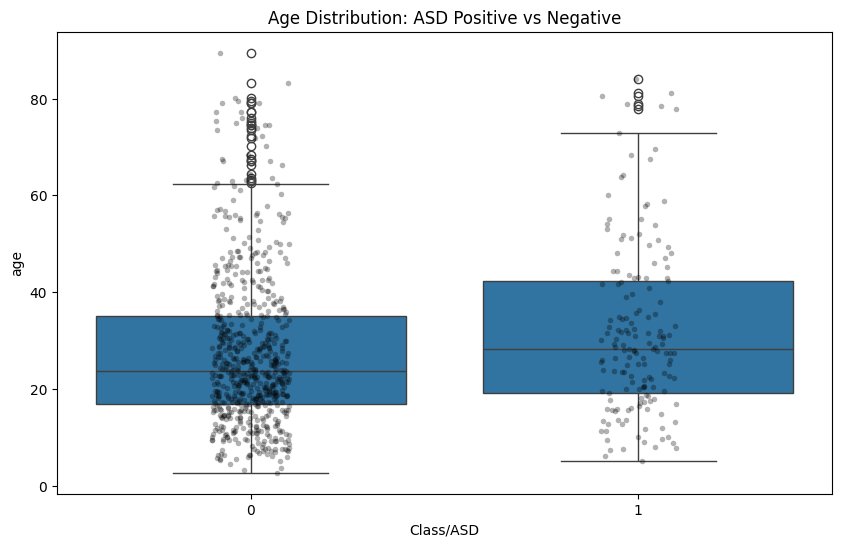

In [ ]:
#@title Mann-Whiteney U Test
def perform_mann_whitney_test(data, group_column, value_column, group1, group2):
    """
    Perform Mann-Whitney U test between two groups.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    group_column : str
        Column name containing group labels
    value_column : str
        Column name containing values to compare
    group1 : str/int
        Label of first group
    group2 : str/int
        Label of second group
    
    Returns:
    --------
    tuple
        (U statistic, p-value)
    """
    # Extract values for each group
    group1_values = data[data[group_column] == group1][value_column]
    group2_values = data[data[group_column] == group2][value_column]
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(
        group1_values, 
        group2_values, 
        alternative='two-sided'
    )
    
    return statistic, p_value

def plot_group_comparison(data, group_column, value_column, group1, group2, title=None):
    """
    Create a box plot comparing the distribution of values between two groups.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    group_column : str
        Column name containing group labels
    value_column : str
        Column name containing values to compare
    group1 : str/int
        Label of first group
    group2 : str/int
        Label of second group
    title : str, optional
        Plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Create box plot
    sns.boxplot(x=group_column, y=value_column, data=data[data[group_column].isin([group1, group2])])
    
    # Add individual points
    sns.stripplot(x=group_column, y=value_column, data=data[data[group_column].isin([group1, group2])],
                 color='black', alpha=0.3, size=4)
    
    if title:
        plt.title(title)
    plt.show()
    
# Example: Compare age distribution between ASD positive and negative groups
statistic, p_value = perform_mann_whitney_test(
    train, 
    'Class/ASD', 
    'age',
    1,  # ASD positive
    0   # ASD negative
)

print(f"Mann-Whitney U test results:")
print(f"U statistic: {statistic:.2f}")
print(f"p-value: {p_value:.4f}")

# Create visualization
plot_group_comparison(
    train,
    'Class/ASD',
    'age',
    1,
    0,
    title='Age Distribution: ASD Positive vs Negative'
) 

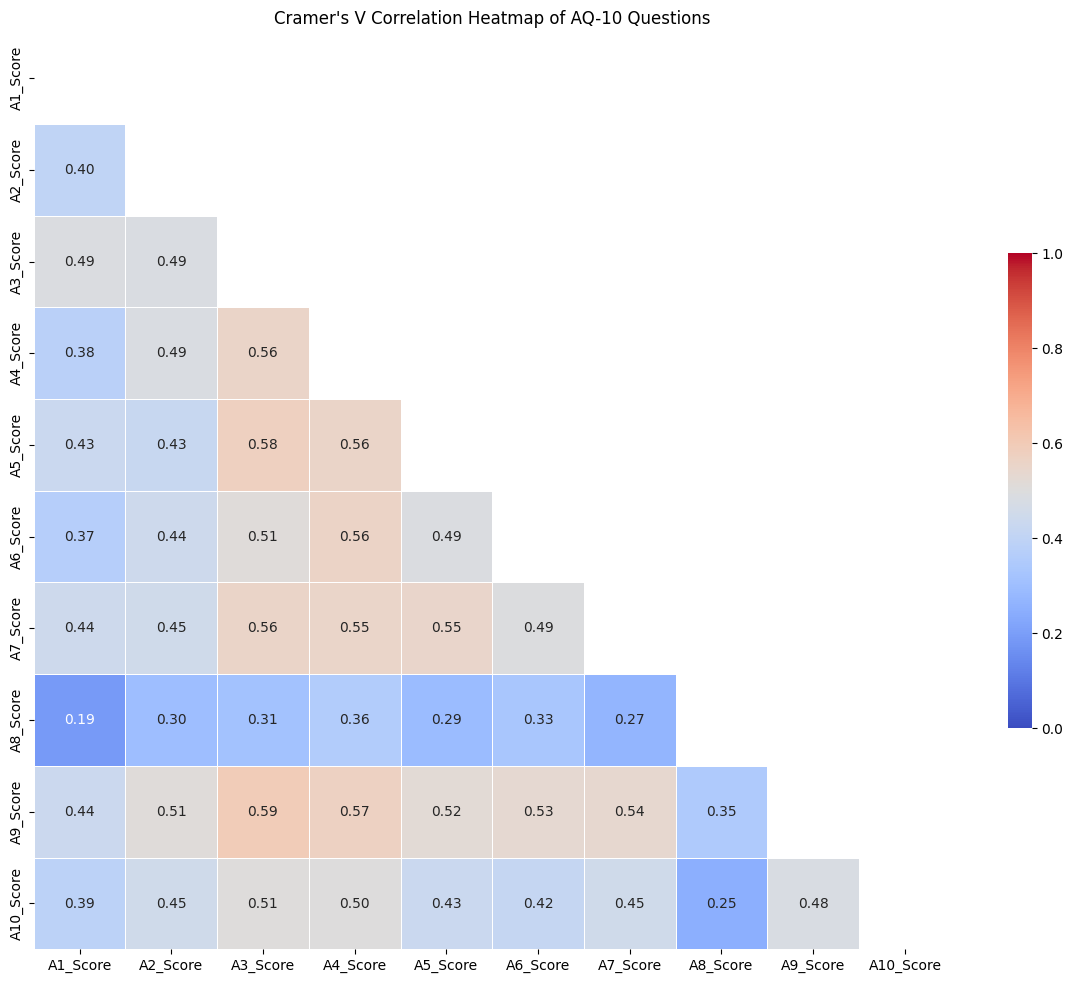


Top 5 strongest correlations between AQ-10 questions:
A3_Score - A9_Score: 0.595
A3_Score - A5_Score: 0.577
A4_Score - A9_Score: 0.574
A4_Score - A6_Score: 0.561
A4_Score - A5_Score: 0.557


In [ ]:
#@title Cramér’s V
def cramers_v(confusion_matrix):
    """
    Calculate Cramer's V statistic for categorical-categorical association.
    
    Parameters:
    -----------
    confusion_matrix : numpy.ndarray
        The confusion matrix (contingency table)
    
    Returns:
    --------
    float
        Cramer's V statistic
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    
    return np.sqrt(chi2 / (n * min_dim))

def calculate_cramers_v_matrix(data, columns):
    """
    Calculate Cramer's V for all pairs of categorical variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    columns : list
        List of column names to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Matrix of Cramer's V values
    """
    n_cols = len(columns)
    cramers_v_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                cramers_v_matrix[i, j] = 1.0
            else:
                confusion_matrix = pd.crosstab(data[columns[i]], data[columns[j]])
                cramers_v_matrix[i, j] = cramers_v(confusion_matrix)
    
    return pd.DataFrame(cramers_v_matrix, index=columns, columns=columns)

def plot_correlation_heatmap(correlation_matrix, title="Cramer's V Correlation Heatmap"):
    """
    Create a heatmap visualization of the correlation matrix.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        The correlation matrix to visualize
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=0,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Get AQ-10 score columns
aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]

# Calculate Cramer's V matrix
cramers_v_matrix = calculate_cramers_v_matrix(train, aq_columns)

# Plot correlation heatmap
plot_correlation_heatmap(
    cramers_v_matrix,
    title="Cramer's V Correlation Heatmap of AQ-10 Questions"
)

# Print some insights
print("\nTop 5 strongest correlations between AQ-10 questions:")
# Get upper triangle of correlation matrix
upper_triangle = cramers_v_matrix.where(np.triu(np.ones(cramers_v_matrix.shape), k=1).astype(bool))
# Stack and sort
correlations = upper_triangle.stack().sort_values(ascending=False)
for (q1, q2), corr in correlations.head().items():
    print(f"{q1} - {q2}: {corr:.3f}") 

## Polychoric Correlation

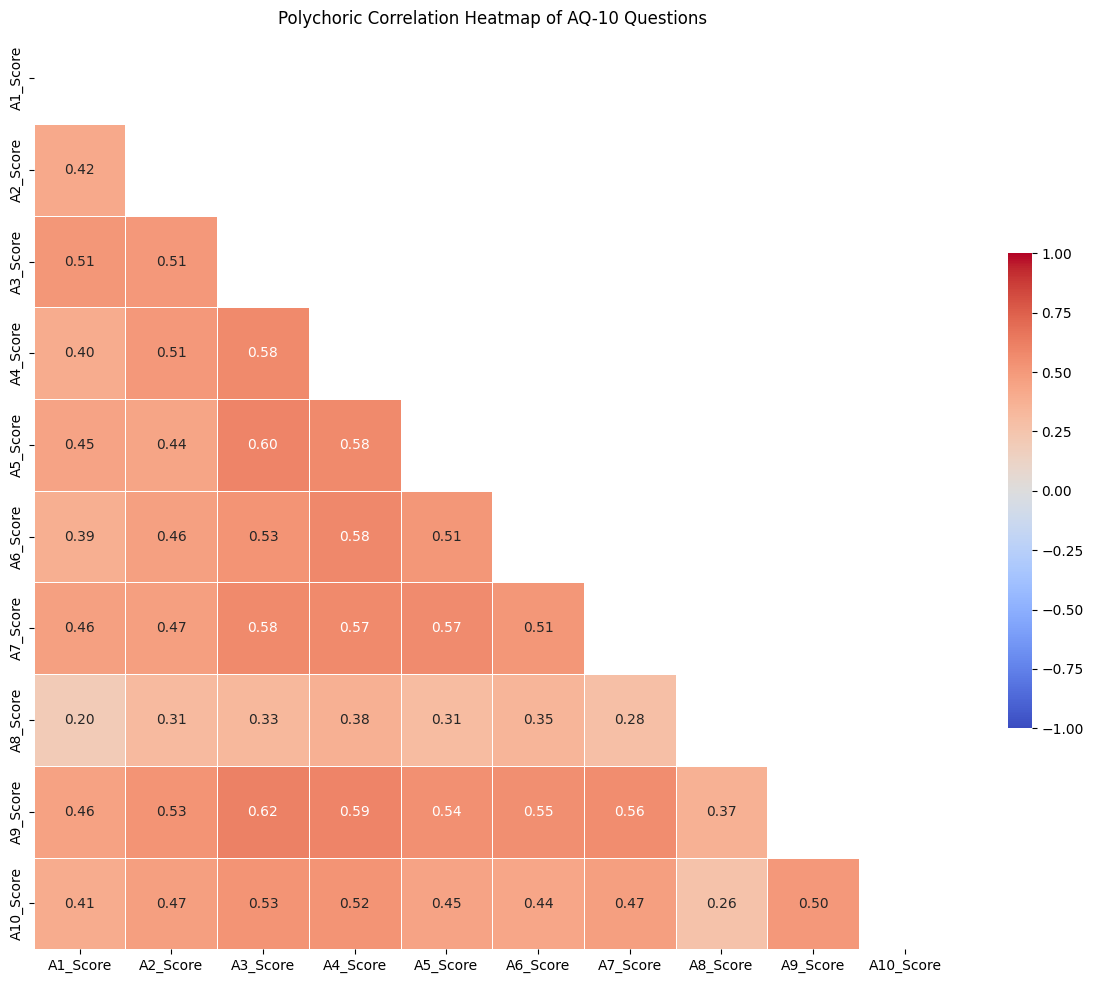


Top 5 strongest correlations between AQ-10 questions:
A3_Score - A9_Score: 0.615
A3_Score - A5_Score: 0.598
A4_Score - A9_Score: 0.595
A4_Score - A6_Score: 0.582
A4_Score - A5_Score: 0.578


In [ ]:
#@title Polychoric correlation
def polychoric_approx(x, y):
    """
    Calculate an approximation of polychoric correlation
    using Pearson correlation with a correction factor.
    
    Parameters:
    -----------
    x : pandas.Series
        First ordinal variable
    y : pandas.Series
        Second ordinal variable
        
    Returns:
    --------
    float
        Approximate polychoric correlation coefficient
    """
    # Handle missing values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Use Spearman correlation as starting point
    rho_spearman, _ = stats.spearmanr(x_clean, y_clean)
    
    # Apply correction to approximate polychoric correlation
    # This uses a common rule of thumb for converting Spearman to polychoric
    rho_polychoric = 2 * np.sin(np.pi * rho_spearman / 6)
    
    return rho_polychoric

def calculate_polychoric_matrix(data, columns):
    """
    Calculate polychoric correlation for all pairs of ordinal variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    columns : list
        List of column names to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Matrix of polychoric correlation values
    """
    n_cols = len(columns)
    polychoric_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                polychoric_matrix[i, j] = 1.0
            else:
                polychoric_matrix[i, j] = polychoric_approx(data[columns[i]], data[columns[j]])
    
    return pd.DataFrame(polychoric_matrix, index=columns, columns=columns)

def plot_polychoric_heatmap(correlation_matrix, title="Polychoric Correlation Heatmap"):
    """
    Create a heatmap visualization of the polychoric correlation matrix.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        The correlation matrix to visualize
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:
# Get AQ-10 score columns
aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]

# Calculate polychoric correlation matrix
polychoric_matrix = calculate_polychoric_matrix(train, aq_columns)

# Plot correlation heatmap
plot_polychoric_heatmap(
    polychoric_matrix, 
    title="Polychoric Correlation Heatmap of AQ-10 Questions"
)

# Print some insights
print("\nTop 5 strongest correlations between AQ-10 questions:")
# Get upper triangle of correlation matrix
upper_triangle = polychoric_matrix.where(np.triu(np.ones(polychoric_matrix.shape), k=1).astype(bool))
# Take absolute values for the strongest correlations (positive or negative)
abs_correlations = upper_triangle.abs().stack().sort_values(ascending=False)
for (q1, q2), corr in abs_correlations.head().items():
    actual_corr = upper_triangle.loc[q1, q2]
    print(f"{q1} - {q2}: {actual_corr:.3f}")

# Phase 2: Supervised Learning Benchmarks

## Data Preprocessing


In [40]:
# Display the shape of the training data
print(train.shape)
print(train.head())

# Create country_label mapping based on the ratio of positive to negative cases
country_label = (train[train['Class/ASD'] == 1]['contry_of_res'].value_counts() / 
                train[train['Class/ASD'] == 0]['contry_of_res'].value_counts() * 
                train['contry_of_res'].value_counts()).sort_values(ascending=False)
country_label = country_label.map(lambda x: 0 if np.isnan(x) else x)
# Normalize to [0,1] range
country_label = dict((country_label - min(country_label))/(max(country_label) - min(country_label)))

# Add default values for countries that might be missing
for item in ['Uruguay', 'Lebanon', 'Philippines']:
    country_label[item] = 0

# Create ethnicity mapping
eth_label = train.loc[:, ['ethnicity', 'Class/ASD']]
# Map similar categories
mapper = {
    '?': 'others',
    'Others': 'others'
}
eth_label['ethnicity'] = eth_label['ethnicity'].map(lambda x: mapper[x] if x in mapper else x)
# Calculate ratio similar to country mapping
eth_label = (eth_label[eth_label['Class/ASD'] == 1]['ethnicity'].value_counts() / 
            eth_label[eth_label['Class/ASD'] == 0]['ethnicity'].value_counts() * 
            eth_label['ethnicity'].value_counts()).sort_values(ascending=False)
eth_label = eth_label.map(lambda x: 0 if np.isnan(x) else x)
# Normalize to [0,1] range
eth_label = dict((eth_label - min(eth_label))/(max(eth_label) - min(eth_label)))

# Define preprocessing function
def preprocess(data):
    data_temp = data.copy()
    
    # Drop columns
    data_temp = data_temp.drop(['relation', 'used_app_before'], axis=1)
    
    # Encode binary categorical variables
    data_temp['gender'] = data_temp['gender'].map(lambda x: 1 if x == 'm' else 0)
    data_temp['jaundice'] = data_temp['jaundice'].map(lambda x: 1 if x == 'yes' else 0)
    data_temp['austim'] = data_temp['austim'].map(lambda x: 1 if x == 'yes' else 0)
    
    # Encode ethnicity using the mapping
    data_temp['ethnicity'] = data_temp['ethnicity'].map(lambda x: 'others' if (x == 'Others' or x == '?') else x)
    data_temp['ethnicity'] = data_temp['ethnicity'].map(eth_label)
    
    # Encode country using the mapping
    data_temp['contry_of_res'] = data_temp['contry_of_res'].map(country_label)
    
    # Normalize numerical features
    data_temp['age'] = (data_temp['age'] - min(data_temp['age']))/(max(data_temp['age']) - min(data_temp['age']))
    data_temp['result'] = (data_temp['result'] - min(data_temp['result']))/(max(data_temp['result']) - min(data_temp['result']))
    
    return data_temp

# Apply preprocessing
preprocessed_train = preprocess(train)

print(preprocessed_train.head())


# Set random seed
SEED = 16
np.random.seed(SEED)

# Separate features (X) and target (y)
X = preprocessed_train.drop('Class/ASD', axis=1)
y = preprocessed_train['Class/ASD']

# Split data for visualization purposes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Calculate the ratio of negative to positive samples
neg_pos_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

# 3x stratified 10 fold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

# Display shapes of data
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X columns:", list(X.columns))


(800, 20)
   A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0         1         0         1         0         1         0         1   
1         0         0         0         0         0         0         0   
2         1         1         1         1         1         1         1   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score        age gender       ethnicity jaundice  \
0         0         1          1  38.172746      f         Unknown       no   
1         0         0          0  47.750517      m         Unknown       no   
2         1         1          1   7.380373      m  White-European       no   
3         0         0          0  23.561927      f         Unknown       no   
4         0         0          0  43.205790      m         Unknown       no   

  austim  contry_of_res used_app_before     result relation  Cla

TODO: exlain

## Logistic Regression

In [41]:
# graph helpers, collapse me
def plot_confusion_matrix(model, X_test, y_test, ax=None, title="Normalized Confusion Matrix"):
    """Plot a confusion matrix for the model predictions."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(title, fontsize=14)
    return ax

def plot_roc_curve(model, X_test, y_test, ax=None, title="ROC Curve"):
    """Plot the ROC curve for the model."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="lower right")
    return ax

def plot_precision_recall_curve(model, X_test, y_test, ax=None, title="Precision-Recall Curve"):
    """Plot the precision-recall curve for the model."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_precision = average_precision_score(y_test, y_score)
    
    ax.plot(recall, precision, color='blue', lw=2,
            label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="best")
    return ax

def plot_permutation_importance(model, X_test, y_test, ax=None, title="Permutation Feature Importance", random_state=42):
    """Plot permutation feature importance for the model."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=random_state, n_jobs=-1
    )
    
    # Sort features by importance
    sorted_idx = result.importances_mean.argsort()
    
    # Plot
    ax.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=X_test.columns[sorted_idx]
    )
    ax.set_title(title, fontsize=14)
    return ax

def print_cv_results(cv_results, scoring_dict, model_name="Model"):
    """Print cross-validation results in a formatted way."""
    print(f"{model_name.upper()} RESULTS:")
    for metric in scoring_dict.keys():
        scores = cv_results[f'test_{metric}']
        print(f"{metric.upper()}:")
        print(f"  Mean: {np.mean(scores):.4f}")
        print(f"  Std Dev: {np.std(scores):.4f}")
        print(f"  Min: {np.min(scores):.4f}")
        print(f"  Max: {np.max(scores):.4f}")

def create_model_dashboard(model, X_test, y_test, cv_results, scoring_dict, model_name="Model"):
    """Create a comprehensive dashboard of model performance."""
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Plot each visualization
    plot_confusion_matrix(model, X_test, y_test, ax=axes[0, 0])
    plot_roc_curve(model, X_test, y_test, ax=axes[0, 1])
    plot_precision_recall_curve(model, X_test, y_test, ax=axes[1, 0])
    plot_permutation_importance(model, X_test, y_test, ax=axes[1, 1])
    
    # Add a title to the entire figure
    fig.suptitle(f"{model_name} Performance Dashboard", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
    
    # Print CV results
    print_cv_results(cv_results, scoring_dict, model_name)
    
    plt.show()

In [42]:
# Define hyperparam objectives
def lr_objective(trial):
    # Define hyperparameters to tune
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    C = trial.suggest_float("C", 1e-3, 10, log=True)
    
    # Conditional hyperparameters
    params = {
        "penalty": penalty,
        "solver": "saga",
        "C": C,
        "max_iter": 5000,
        "class_weight": "balanced",
        "random_state": SEED
    }
    
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0, 1)
    
    # Create pipeline with the suggested hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(**params))
    ])
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=cv, 
        scoring="balanced_accuracy",
        n_jobs=-1
    )
    
    return scores.mean()

C:\Users\33322\AppData\Local\Temp\ipykernel_26196\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


BASELINE LOGISTIC REGRESSION WITH ELASTIC NET RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8368
  Std Dev: 0.0485
  Min: 0.7109
  Max: 0.9141
ROC_AUC:
  Mean: 0.9095
  Std Dev: 0.0343
  Min: 0.8291
  Max: 0.9629
PR_AUC:
  Mean: 0.7241
  Std Dev: 0.0895
  Min: 0.5755
  Max: 0.9012
F1:
  Mean: 0.6617
  Std Dev: 0.0659
  Min: 0.5128
  Max: 0.7895
MCC:
  Mean: 0.5798
  Std Dev: 0.0874
  Min: 0.3728
  Max: 0.7419


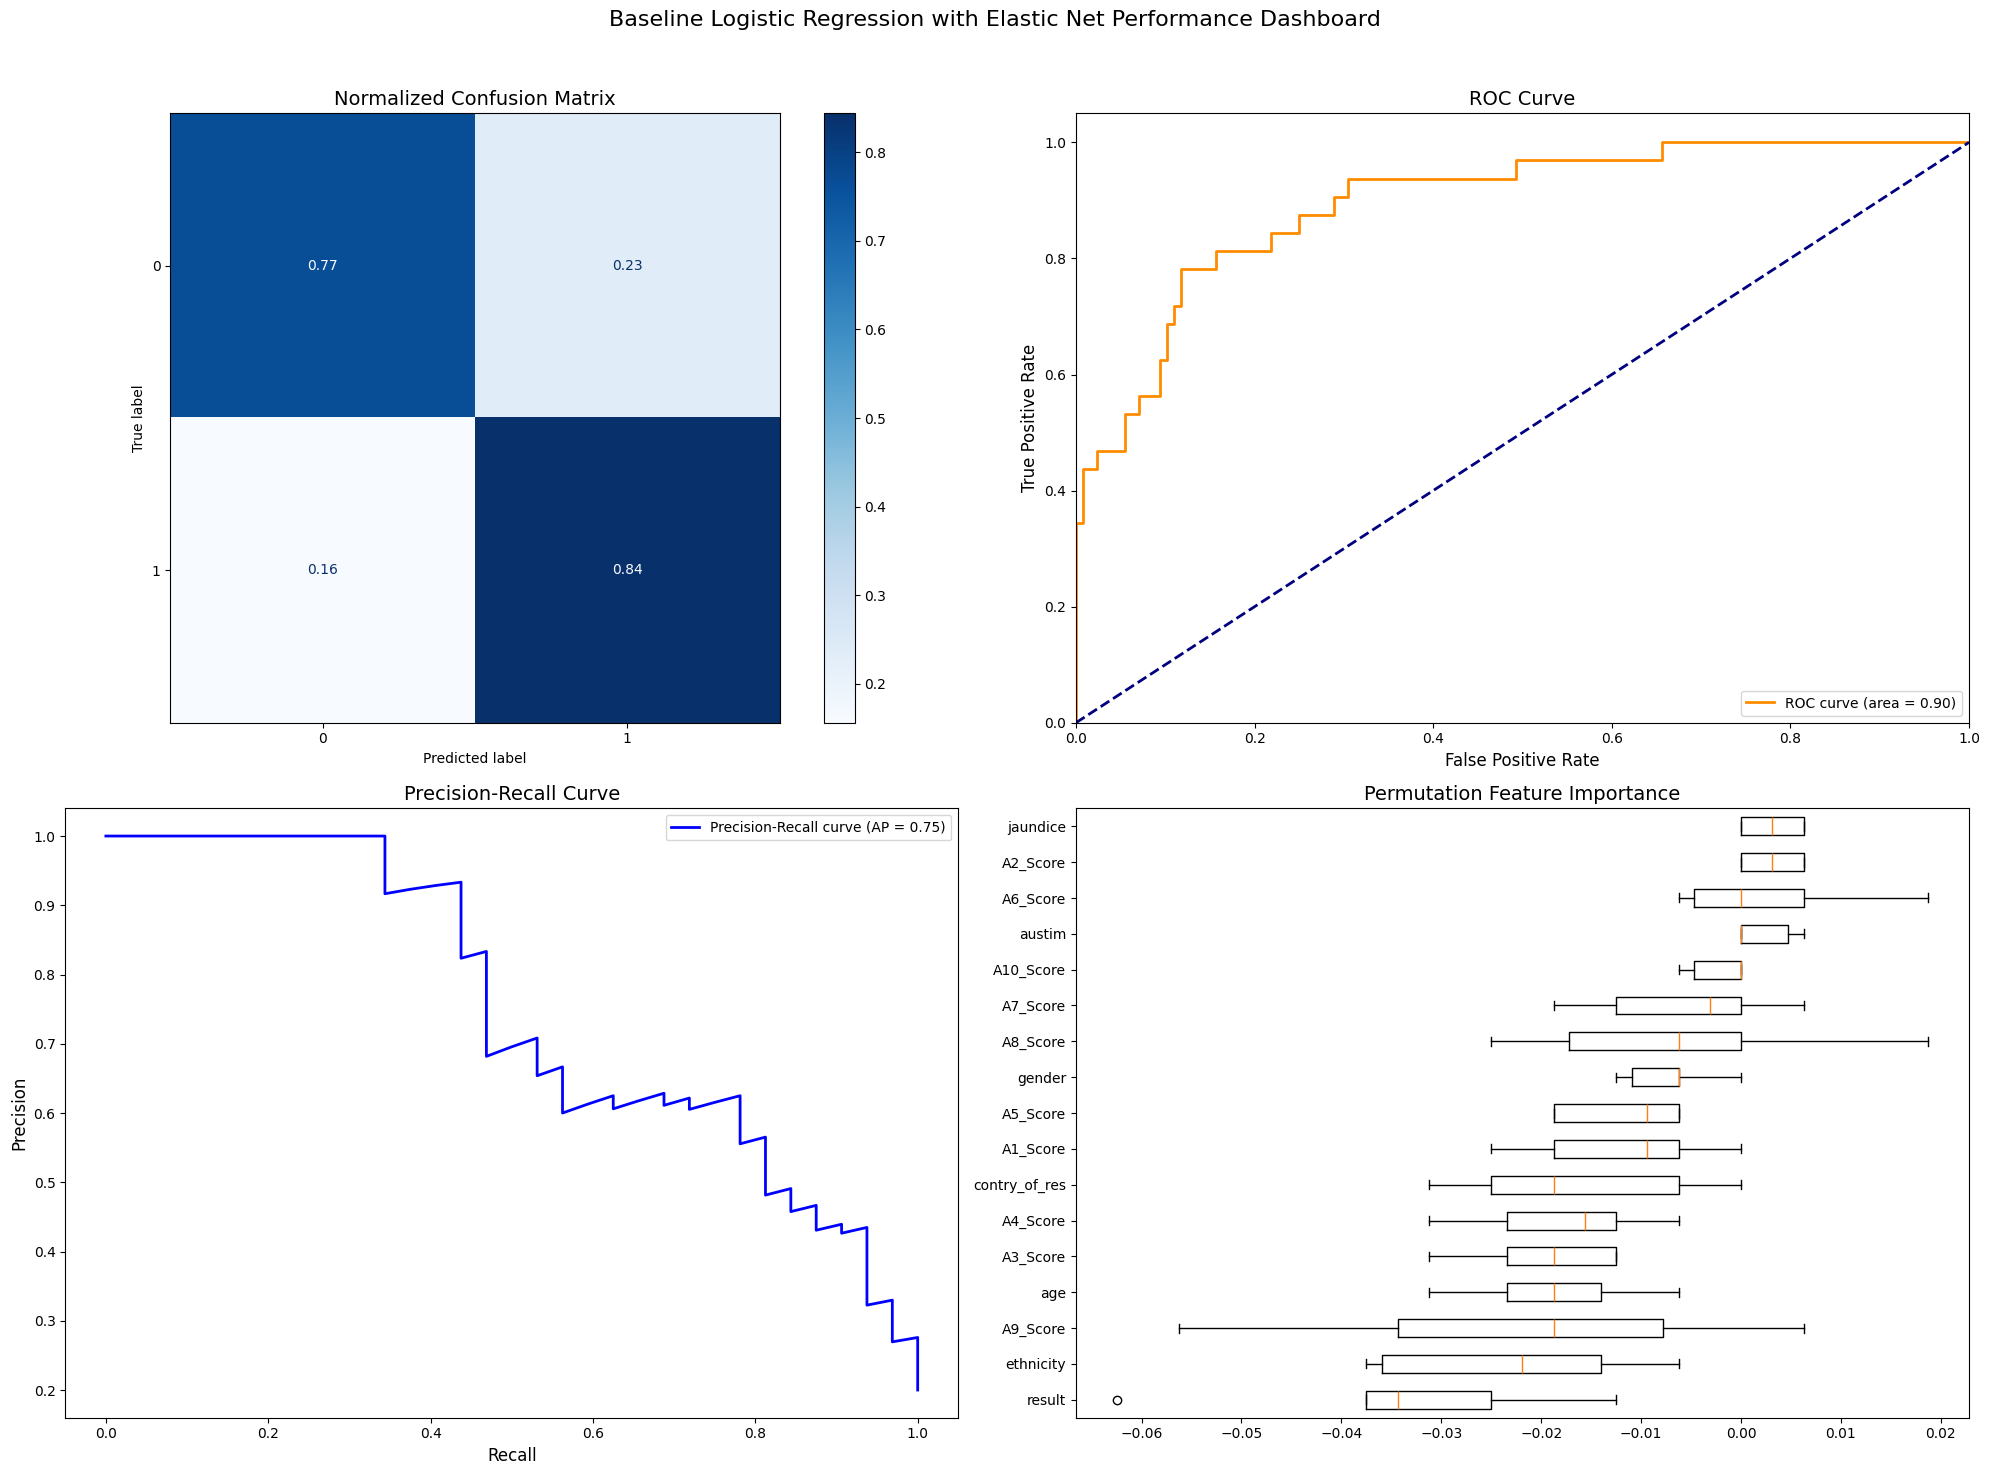

[I 2025-05-11 23:39:58,417] A new study created in memory with name: no-name-e84e0243-f316-4dd7-9116-51e2bbf39eda


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-11 23:39:58,470] Trial 0 finished with value: 0.8443600704170557 and parameters: {'penalty': 'l2', 'C': 0.015823848974727467}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-11 23:39:58,534] Trial 1 finished with value: 0.8407142370837224 and parameters: {'penalty': 'l2', 'C': 0.07695505198013829}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-11 23:39:58,597] Trial 2 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.0020781391508508345}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-11 23:39:58,647] Trial 3 finished with value: 0.8355100373482727 and parameters: {'penalty': 'l2', 'C': 5.022218062194279}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-11 23:39:58,693] Trial 4 finished with value: 0.8440996537503891 and parameters: {'penalty': 'l2', 'C': 0.013140529544538348}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-11 23:39:58,751] Trial 5 finished with value: 0.8399412542794895 and paramete

c:\Users\33322\repos\asd-hackathon-25\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\33322\AppData\Local\Temp\ipykernel_26196\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


OPTIMIZED LOGISTIC REGRESSION RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8482
  Std Dev: 0.0428
  Min: 0.7578
  Max: 0.9141
ROC_AUC:
  Mean: 0.9199
  Std Dev: 0.0319
  Min: 0.8545
  Max: 0.9717
PR_AUC:
  Mean: 0.7383
  Std Dev: 0.0931
  Min: 0.5366
  Max: 0.9200
F1:
  Mean: 0.6710
  Std Dev: 0.0584
  Min: 0.5581
  Max: 0.8000
MCC:
  Mean: 0.5952
  Std Dev: 0.0777
  Min: 0.4362
  Max: 0.7490


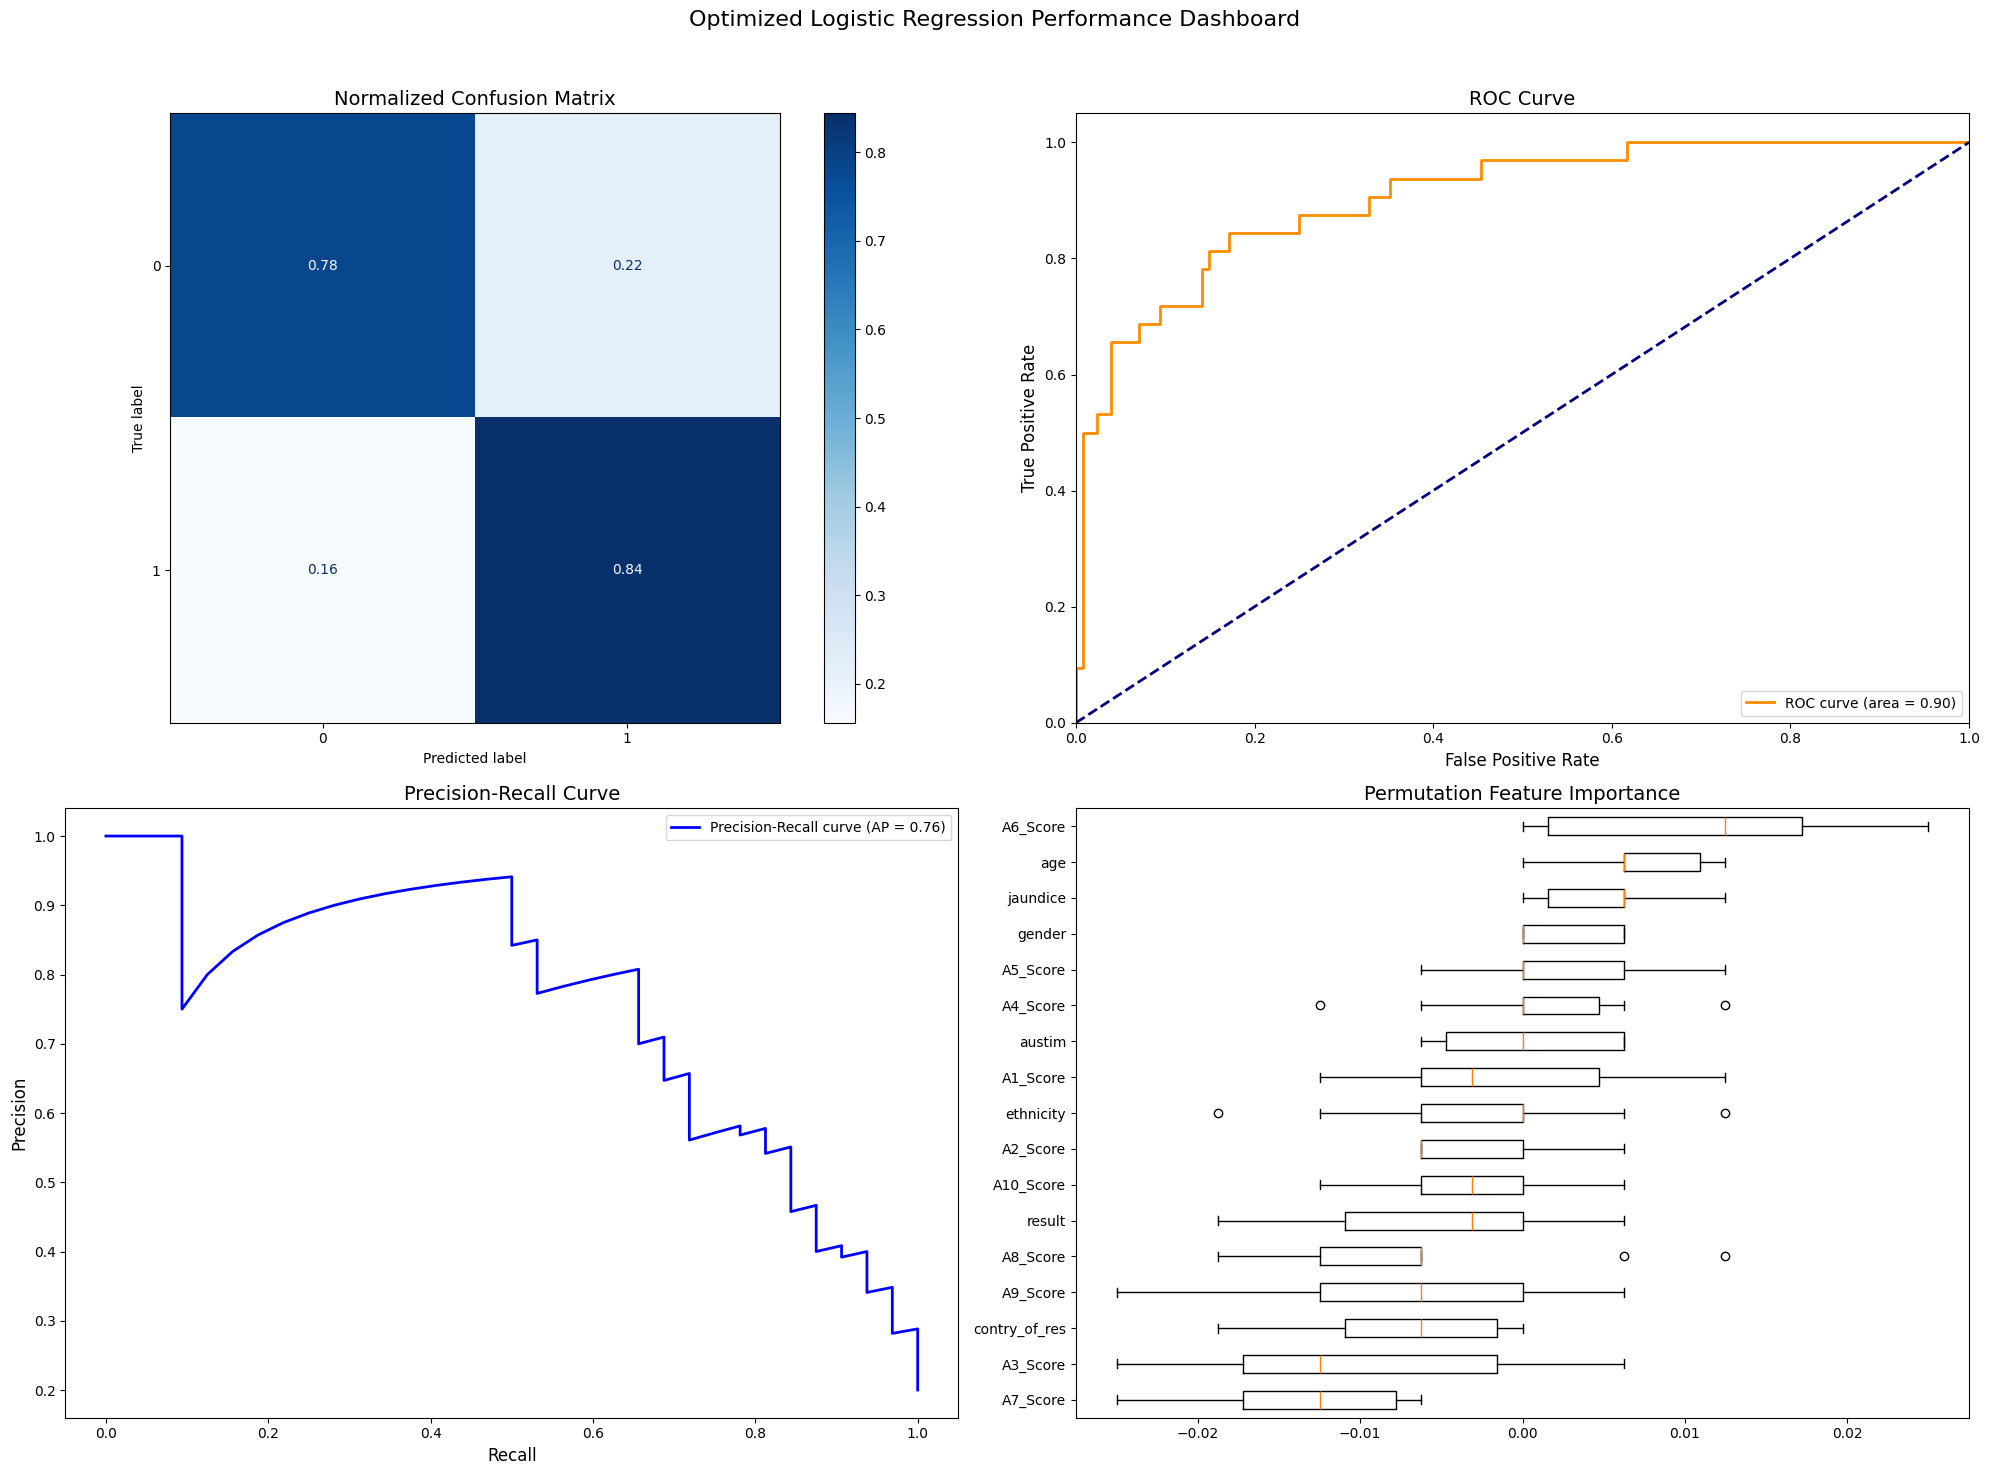


Performance Comparison (Baseline vs Optimized):
balanced_accuracy: 0.8368 → 0.8482 (+1.36%)
roc_auc: 0.9095 → 0.9199 (+1.14%)
pr_auc: 0.7241 → 0.7383 (+1.96%)
f1: 0.6617 → 0.6710 (+1.42%)
mcc: 0.5798 → 0.5952 (+2.65%)


In [43]:
baseline_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.5,
        max_iter=5000,
        class_weight='balanced',
        random_state=SEED
    ))
])


# Fit the baseline pipeline
baseline_lr_pipeline.fit(X_train, y_train)

scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'mcc': 'matthews_corrcoef'
}

# Evaluate baseline model
baseline_lr_scores = cross_validate(
    baseline_lr_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Create dashboard for baseline model
create_model_dashboard(
    model=baseline_lr_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=baseline_lr_scores,
    scoring_dict=scoring,
    model_name="Baseline Logistic Regression with Elastic Net"
)

# Create and run the optimization study at top level
lr_study = optuna.create_study(direction="maximize")
lr_study.optimize(lr_objective, n_trials=50, show_progress_bar=True)

# Get best parameters and score
best_params = lr_study.best_params
best_score = lr_study.best_value
print(f"Best parameters: {best_params}")
print(f"Best balanced accuracy: {best_score:.4f}")

# Create optimized pipeline with best parameters
optimized_params = best_params.copy()
optimized_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty=optimized_params.pop("penalty"),
        solver="saga",
        C=optimized_params.pop("C"),
        l1_ratio=optimized_params.pop("l1_ratio", 0.5),  # Only used if penalty is elasticnet
        max_iter=5000,
        class_weight='balanced',
        random_state=SEED
    ))
])

# Fit the optimized pipeline
optimized_lr_pipeline.fit(X_train, y_train)

# Evaluate optimized model
optimized_lr_scores = cross_validate(
    optimized_lr_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Create dashboard for optimized model
create_model_dashboard(
    model=optimized_lr_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=optimized_lr_scores,
    scoring_dict=scoring,
    model_name="Optimized Logistic Regression"
)

# Compare baseline and optimized results
print("\nPerformance Comparison (Baseline vs Optimized):")
for metric in scoring.keys():
    baseline_mean = baseline_lr_scores[f'test_{metric}'].mean()
    optimized_mean = optimized_lr_scores[f'test_{metric}'].mean()
    improvement = ((optimized_mean - baseline_mean) / baseline_mean) * 100
    print(f"{metric}: {baseline_mean:.4f} → {optimized_mean:.4f} ({improvement:+.2f}%)")

In [44]:
catboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=SEED,
        class_weights=[1, len(y_train[y_train==0])/len(y_train[y_train==1])],  # Balanced weights
        verbose=False
    ))
])

catboost_pipeline.fit(X_train, y_train)

catboost_scores = cross_validate(
    catboost_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1  # all cores
)

create_model_dashboard(
    model=catboost_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=catboost_scores,
    scoring_dict=scoring,
    model_name="Catboost"
)

KeyboardInterrupt: 

RANDOM FOREST RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8304
  Std Dev: 0.0539
  Min: 0.7344
  Max: 0.9531
ROC_AUC:
  Mean: 0.9183
  Std Dev: 0.0307
  Min: 0.8672
  Max: 0.9668
PR_AUC:
  Mean: 0.7232
  Std Dev: 0.0931
  Min: 0.5307
  Max: 0.9058
F1:
  Mean: 0.6805
  Std Dev: 0.0766
  Min: 0.5366
  Max: 0.8485
MCC:
  Mean: 0.5970
  Std Dev: 0.1008
  Min: 0.4045
  Max: 0.8118


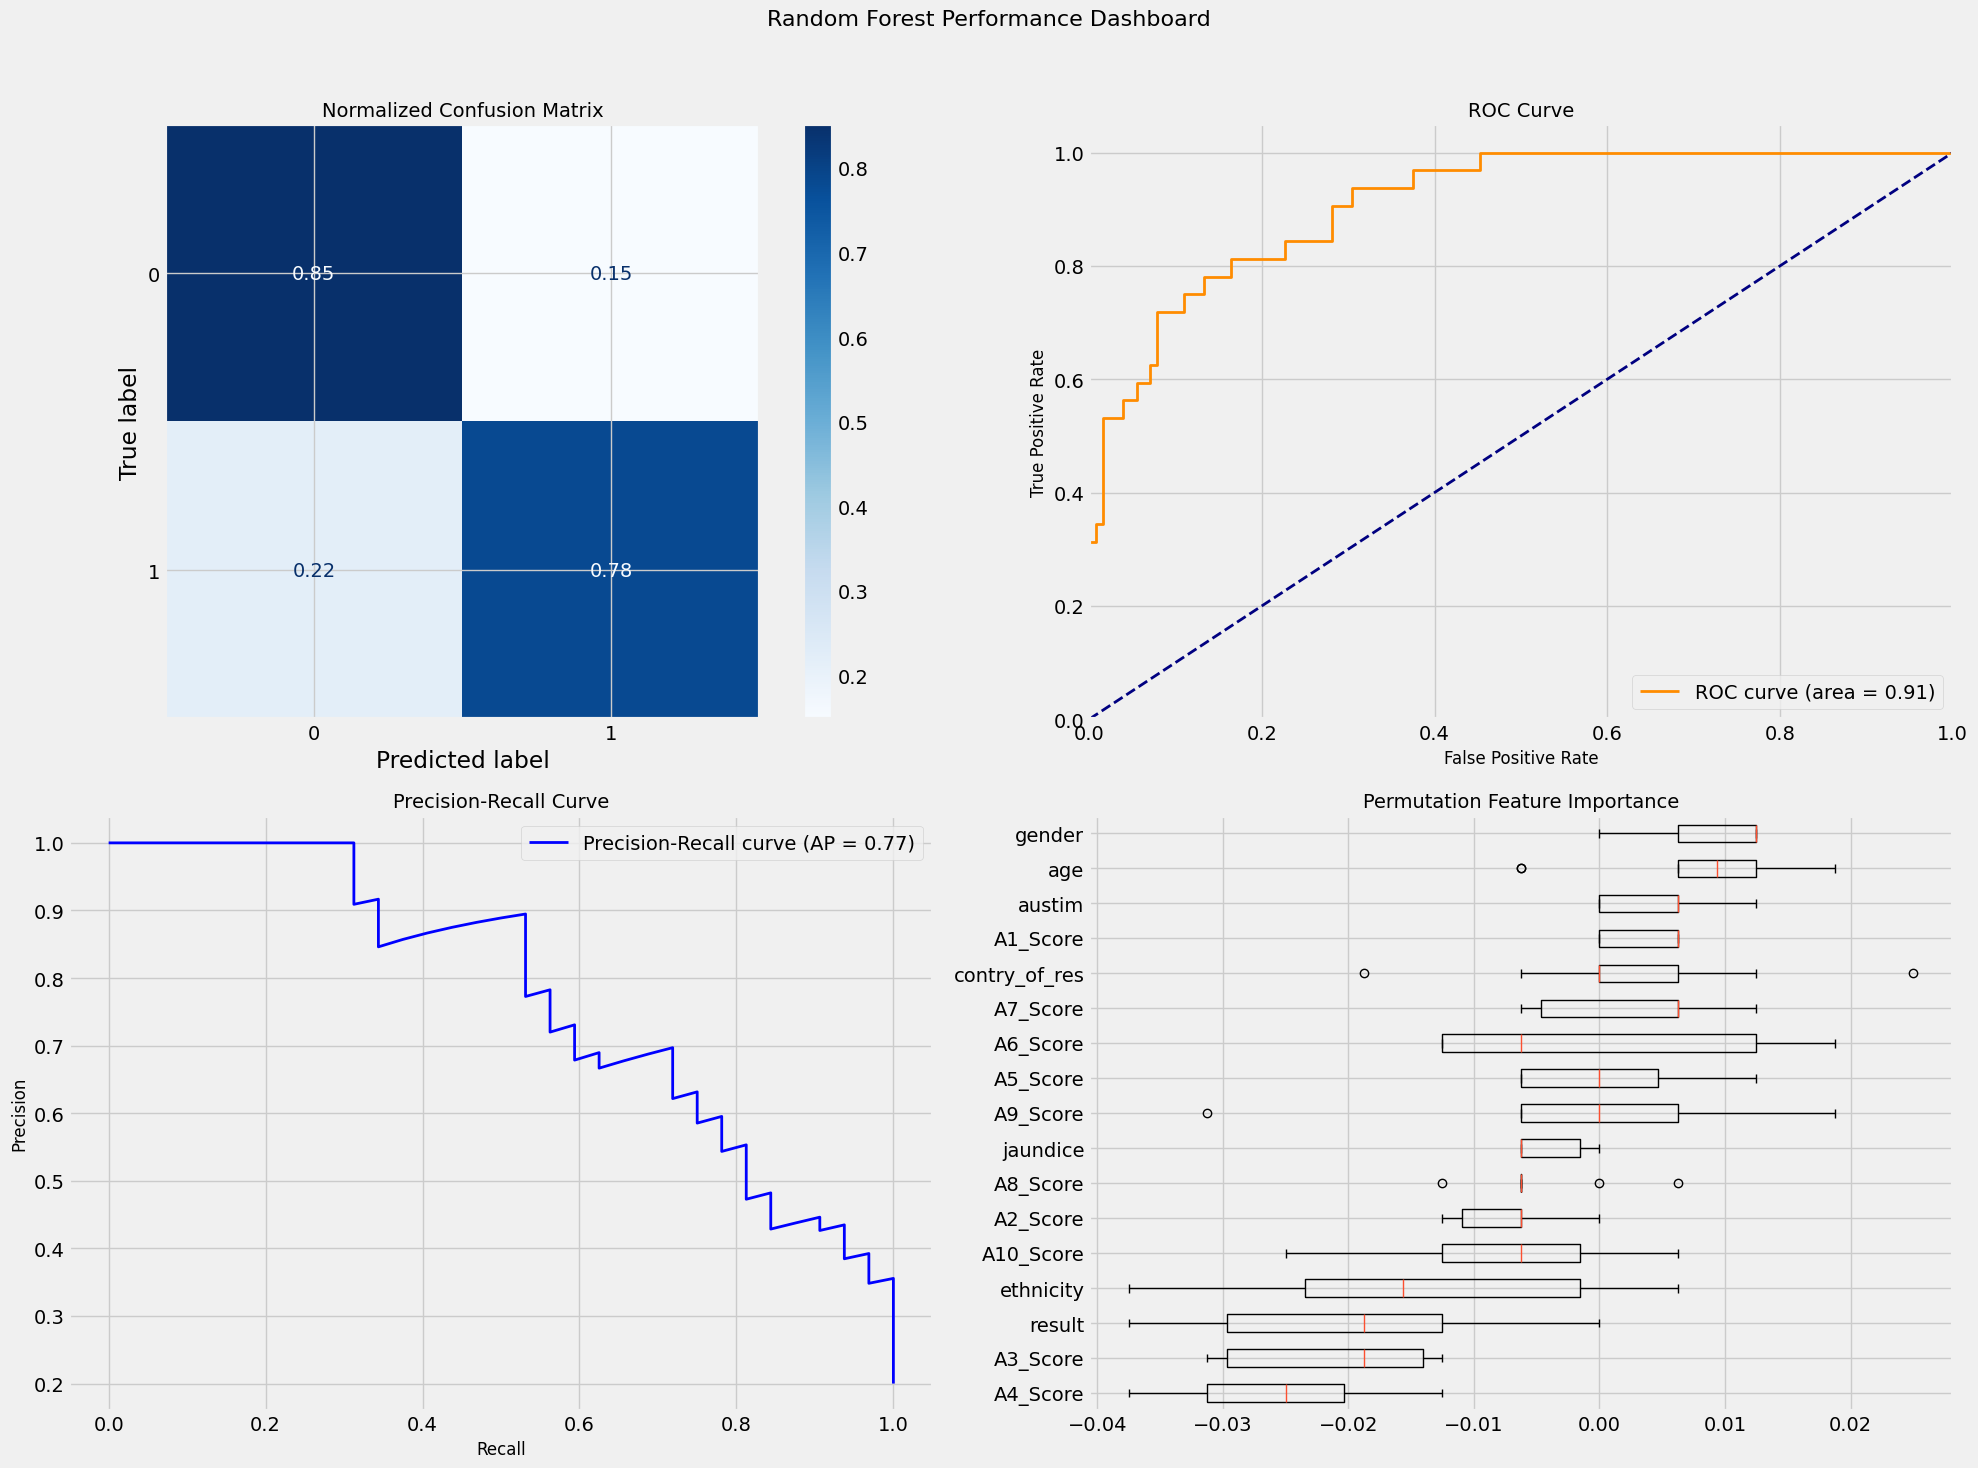

In [627]:
# Define Random Forest pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=1000,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        class_weight='balanced',  # Handles class imbalance
        random_state=SEED,
        n_jobs=-1  # Use all cores for training
    ))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Cross-validation
rf_scores = cross_validate(
    rf_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1  # Use all cores
)

# Create dashboard for model evaluation
create_model_dashboard(
    model=rf_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=rf_scores,
    scoring_dict=scoring,
    model_name="Random Forest"
)

## XGBoost

XGBOOST RESULTS:
BALANCED_ACCURACY:
  Mean: 0.7629
  Std Dev: 0.0523
  Min: 0.6641
  Max: 0.8984
ROC_AUC:
  Mean: 0.8849
  Std Dev: 0.0396
  Min: 0.7852
  Max: 0.9658
PR_AUC:
  Mean: 0.6413
  Std Dev: 0.1033
  Min: 0.4286
  Max: 0.8790
F1:
  Mean: 0.6188
  Std Dev: 0.0791
  Min: 0.4571
  Max: 0.8000
MCC:
  Mean: 0.5245
  Std Dev: 0.0996
  Min: 0.3084
  Max: 0.7490


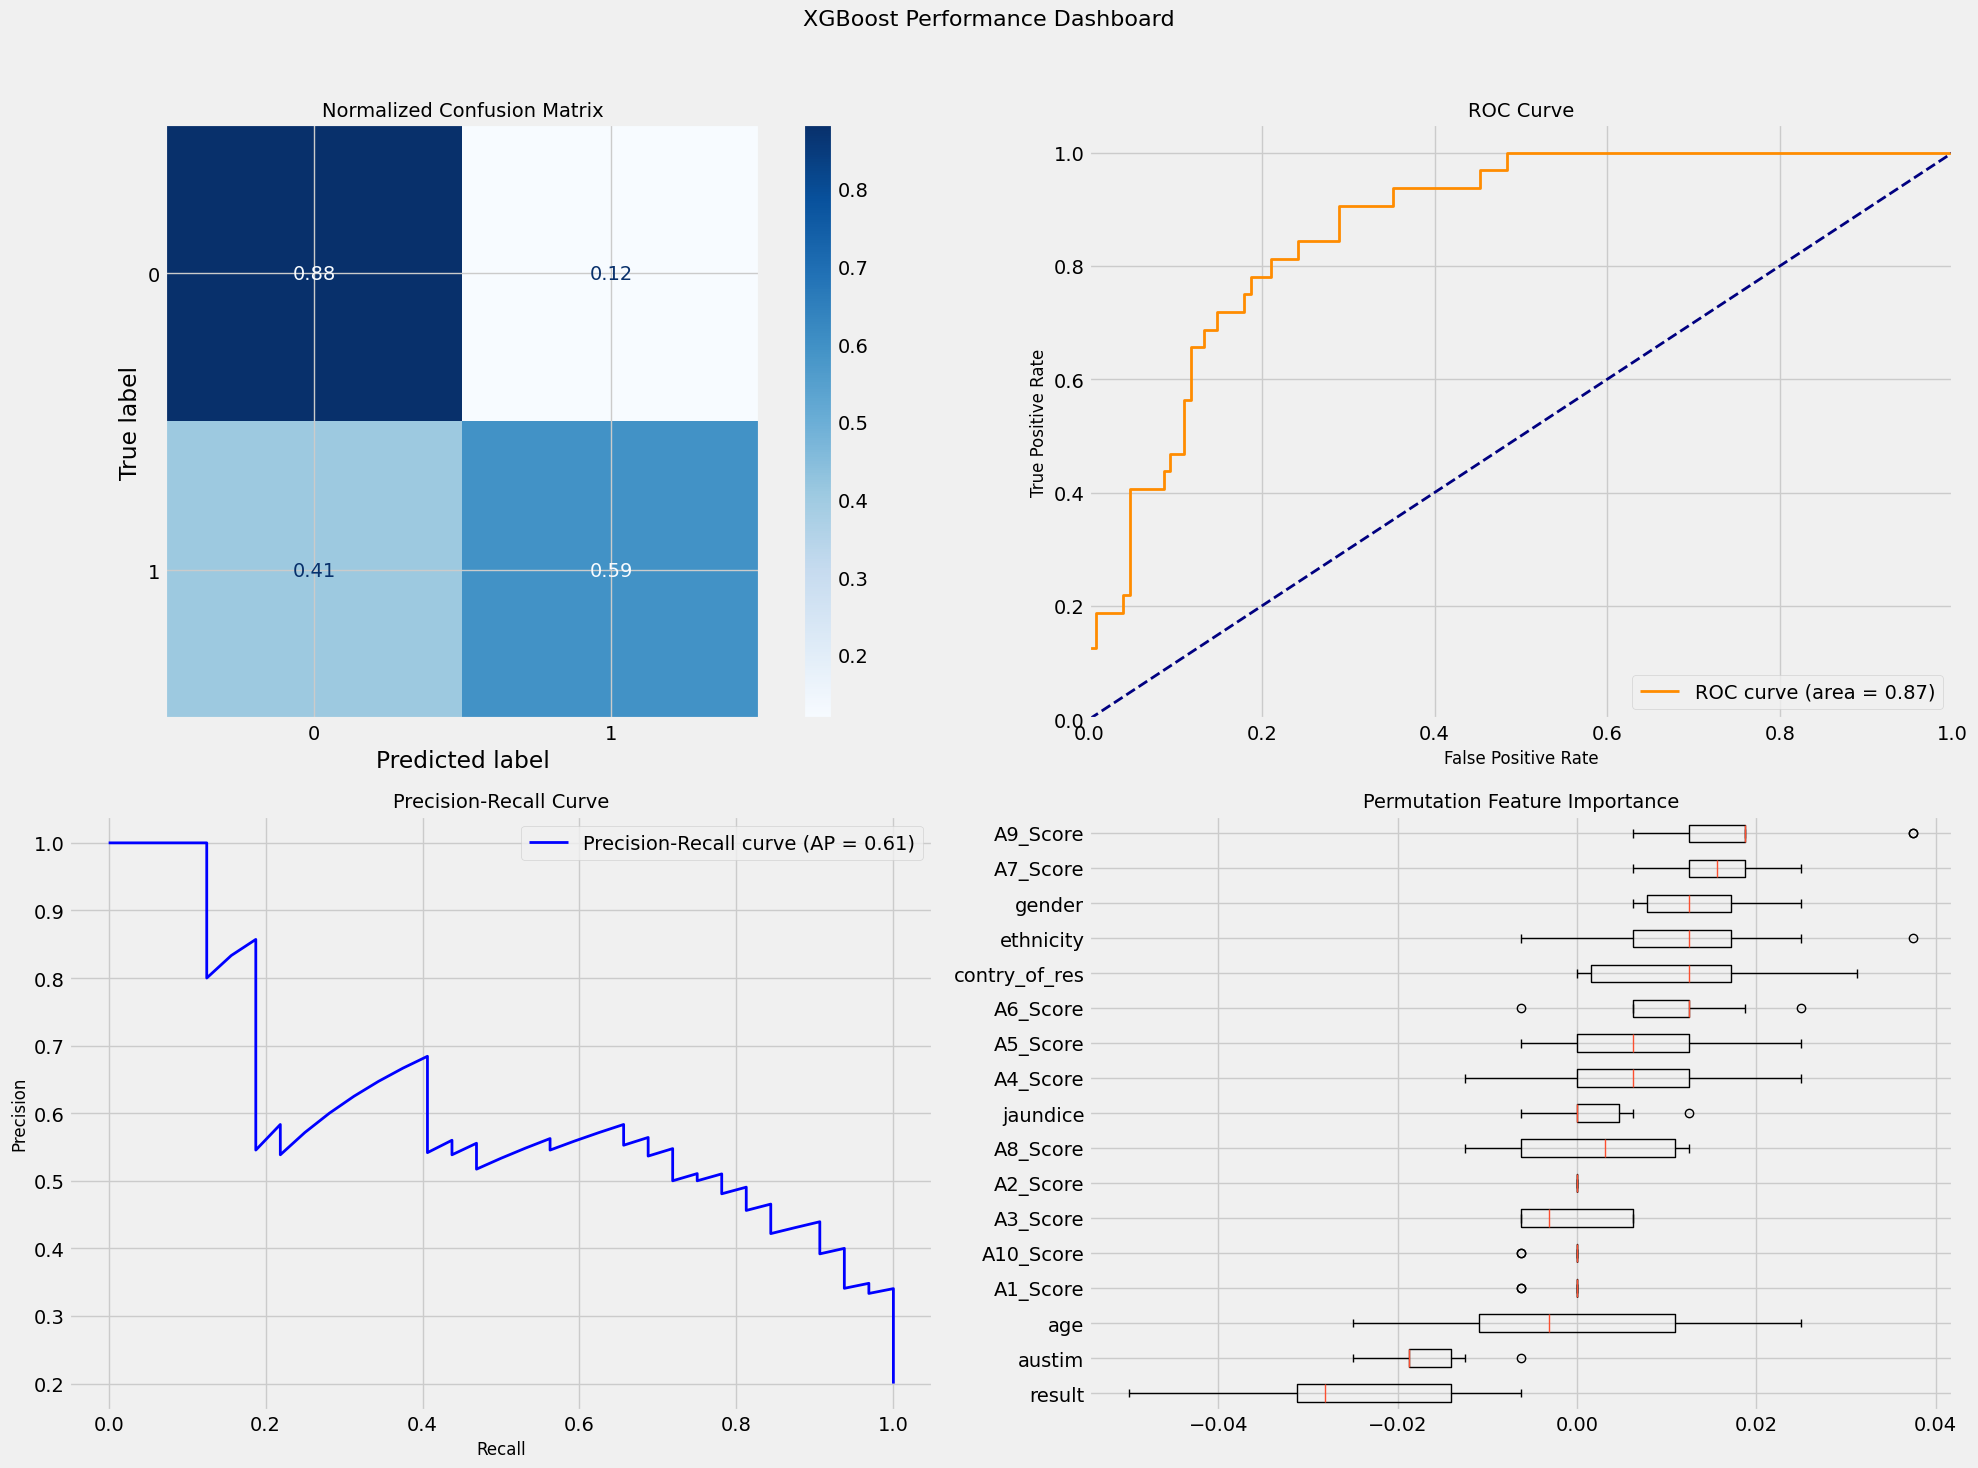

In [ ]:
# Define XGBoost pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=5000,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,        
        scale_pos_weight=neg_pos_ratio,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED,
        n_jobs=-1  # Use all cores for training
    ))
])

# Fit the model
xgb_pipeline.fit(X_train, y_train)

# Cross-validation
xgb_scores = cross_validate(
    xgb_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1  # Use all cores
)

# Create dashboard for model evaluation
create_model_dashboard(
    model=xgb_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=xgb_scores,
    scoring_dict=scoring,
    model_name="XGBoost"
)


## Post-Hyper Parameter Tuning

## Train-Test Split/Adasyn/Scaling


In [ ]:
# Split into training and testing sets
seed = 16
np.random.seed(seed)
# Go back to your train_test_split step and make sure it's done correctly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

# After splitting, check the shapes to confirm they match
print("After train_test_split:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


# Adasyn for handling class imbalance
adasyn = ADASYN(random_state=seed)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# Setup cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=17)

# Helper: get class weights for boosting classes
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

# After adasyn, check the shapes to confirm they match
print("After adasyn:")
print("X_train_bal shape:", X_train_bal.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train_bal shape:", y_train_bal.shape)
print("y_test shape:", y_test.shape)

After train_test_split:
X_train shape: (640, 17)
X_test shape: (160, 17)
y_train shape: (640,)
y_test shape: (160,)
After adasyn:
X_train_bal shape: (997, 17)
X_train_scaled shape: (997, 17)
X_test_scaled shape: (160, 17)
y_train_bal shape: (997,)
y_test shape: (160,)


## Model Tuning Functions

In [630]:
def tune_logreg(X, y, scaler):
    def objective(trial):
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
        C = trial.suggest_float("C", 1e-3, 10, log=True)
        kws = {"penalty": penalty, "solver": "saga", "C": C,
               "max_iter": 5000, "class_weight": "balanced", "random_state": 17}
        if penalty == "elasticnet":
            kws["l1_ratio"] = trial.suggest_float("l1_ratio", 0, 1)
        model = LogisticRegression(**kws)
        return cross_val_score(model, scaler.fit_transform(X), y, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, show_progress_bar=False)
    return study.best_params

def tune_rf(X, y):
    def objective(trial):
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 50, 300),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            class_weight="balanced", random_state=17, n_jobs=-1)
        return cross_val_score(model, X, y, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, show_progress_bar=False)
    return study.best_params

def tune_xgb(X, y):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'random_state': 17,
            'scale_pos_weight': scale_pos_weight,
            'eval_metric': 'logloss',
        }
        model = XGBClassifier(**params)
        # Use n_jobs=-1 for parallelism within XGBoost's cross-validation
        score = cross_val_score(model, X, y, cv=cv, scoring="balanced_accuracy", n_jobs=-1).mean()
        return score
    study = optuna.create_study(direction="maximize")
    # Use pruning to stop unpromising trials early
    study.optimize(objective, n_trials=40, show_progress_bar=True)
    return study.best_params

def tune_cat(X, y):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 50, 200),
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'random_state': 17,
            'scale_pos_weight': scale_pos_weight,
            'verbose': False,
        }
        model = CatBoostClassifier(**params)
        # Use n_jobs=1 for CV since CatBoost handles parallelism internally
        return cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy', n_jobs=1).mean()
    study = optuna.create_study(direction="maximize")
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=20, show_progress_bar=True)
    return study.best_params

## Hyperparam Tuning

In [ ]:
# Function to run all tuning tasks
def run_all_tuning(X_train, y_train, scaler, scale_pos_weight):
    print("Starting optimized hyperparameter tuning...")
    
    # Group models by resource requirements
    # Option 1: Run CPU-only models in parallel, then GPU models sequentially
    
    # CPU-only models (LogReg and RF)
    print("Tuning CPU models in parallel...")
    tune_lr_partial = partial(tune_logreg, scaler=scaler)
    tune_rf_partial = partial(tune_rf)
    
    cpu_tuning_tasks = [
        (tune_lr_partial, "Logistic Regression"),
        (tune_rf_partial, "Random Forest")
    ]
    
    # Run CPU models in parallel with 2 jobs
    cpu_results = joblib.Parallel(n_jobs=2, verbose=10)(
        joblib.delayed(func)(X_train, y_train) for func, _ in cpu_tuning_tasks
    )
    
    results_dict = {
        "Logistic Regression": cpu_results[0],
        "Random Forest": cpu_results[1]
    }
    
    # Run GPU models sequentially to avoid resource contention
    print("Tuning XGBoost model...")
    results_dict["XGBoost"] = tune_xgb(X_train, y_train)
    
    print("Tuning CatBoost model...")
    results_dict["CatBoost"] = tune_cat(X_train, y_train)
    
    return results_dict

# Option to run with predefined parameters or run tuning
run_tuning = True  # Set to False to skip tuning and use defaults

if run_tuning:
    start_time = time.time()
    print("Starting hyperparameter tuning...")
    all_params = run_all_tuning(X_train_bal, y_train_bal, scaler, scale_pos_weight)
    end_time = time.time()
    print(f"Total tuning time: {end_time - start_time:.2f} seconds")
    
    # Extract parameters for each model
    params_lr = all_params["Logistic Regression"]
    params_rf = all_params["Random Forest"]
    params_xgb = all_params["XGBoost"]
    params_cat = all_params["CatBoost"]
else:
    # Use default parameters (you can replace these with known good parameters)
    print("Using default parameters instead of tuning...")
    params_lr = {"penalty": "l2", "C": 1.0}
    params_rf = {"n_estimators": 100, "max_depth": 10, "min_samples_split": 2, "min_samples_leaf": 1}
    params_xgb = {
        "n_estimators": 100, "max_depth": 6, "learning_rate": 0.1,
        "gamma": 0, "subsample": 0.8, "colsample_bytree": 0.8
    }
    params_cat = {"iterations": 100, "depth": 6, "learning_rate": 0.1, "l2_leaf_reg": 3}

print("Best parameters found:")
for model_name, params in all_params.items():
    print(f"{model_name}: {params}")

Starting hyperparameter tuning...
Starting optimized hyperparameter tuning...
Tuning CPU models in parallel...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

## Model Training

In [ ]:
# Define feature importance extraction function
def get_feature_importance(model, name):
    if name == "Logistic Regression":
        return np.abs(model.coef_[0])
    elif name in ["Random Forest", "XGBoost"]:
        return model.feature_importances_
    elif name == "CatBoost":
        return model.get_feature_importance()
    return None

# Define model configurations
model_configs = {
    "Logistic Regression": {
        "model_class": LogisticRegression,
        "params": params_lr,
        "extra_params": {
            "max_iter": 5000,
            "class_weight": "balanced",
            "random_state": 17,
            "solver": "saga"
        },
        "needs_scaling": True,
        "special_handling": lambda params: (
            # Remove l1_ratio if penalty is not 'elasticnet'
            {k: v for k, v in params.items() if k != 'l1_ratio' or params.get('penalty') == 'elasticnet'}
        )
    },
    "Random Forest": {
        "model_class": RandomForestClassifier,
        "params": params_rf,
        "extra_params": {
            "class_weight": "balanced",
            "random_state": 17,
            "n_jobs": -1
        },
        "needs_scaling": False
    },
    "XGBoost": {
        "model_class": XGBClassifier,
        "params": params_xgb,
        "extra_params": {
            "eval_metric": "logloss",
            "random_state": 17
        },
        "needs_scaling": False
    },
    "CatBoost": {
        "model_class": CatBoostClassifier,
        "params": params_cat,
        "extra_params": {
            "verbose": False,
            "random_state": 17
        },
        "needs_scaling": False
    }
}

# Train and evaluate each model
trained_models = {}
results = {}

for name, config in model_configs.items():
    print(f"\nTraining and evaluating: {name}")
    
    # Prepare model parameters
    model_params = config["params"].copy()
    model_params.update(config["extra_params"])
    
    # Apply special parameter handling if needed
    if "special_handling" in config:
        model_params = config["special_handling"](model_params)
    
    # Create and train model
    model = config["model_class"](**model_params)
    
    # Handle data scaling if needed
    X_train_data = scaler.fit_transform(X_train_bal) if config["needs_scaling"] else X_train_bal
    X_test_data = scaler.transform(X_test) if config["needs_scaling"] else X_test
    
    # Fit model
    model.fit(X_train_data, y_train_bal)
    
    # Make predictions
    y_pred = model.predict(X_test_data)
    
    # Get probabilities for ROC/PR curves
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_data)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_data)
    else:
        y_proba = y_pred  # fallback
    
    # Calculate metrics
    acc = balanced_accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Store results
    results[name] = {
        'accuracy': acc,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1': f1,
        'mcc': mcc,
    }
    trained_models[name] = model
    
    print(f"{name} Test Accuracy: {acc:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f} | F1: {f1:.4f} | MCC: {mcc:.4f}")



Training and evaluating: Logistic Regression
Logistic Regression Test Accuracy: 0.7695 | ROC-AUC: 0.8462 | PR-AUC: 0.6172 | F1: 0.5783 | MCC: 0.4627

Training and evaluating: Random Forest
Random Forest Test Accuracy: 0.7891 | ROC-AUC: 0.8591 | PR-AUC: 0.6257 | F1: 0.6154 | MCC: 0.5109

Training and evaluating: XGBoost
XGBoost Test Accuracy: 0.7148 | ROC-AUC: 0.8350 | PR-AUC: 0.5497 | F1: 0.5278 | MCC: 0.3969

Training and evaluating: CatBoost
CatBoost Test Accuracy: 0.7617 | ROC-AUC: 0.8379 | PR-AUC: 0.5390 | F1: 0.5867 | MCC: 0.4723


## Visualization

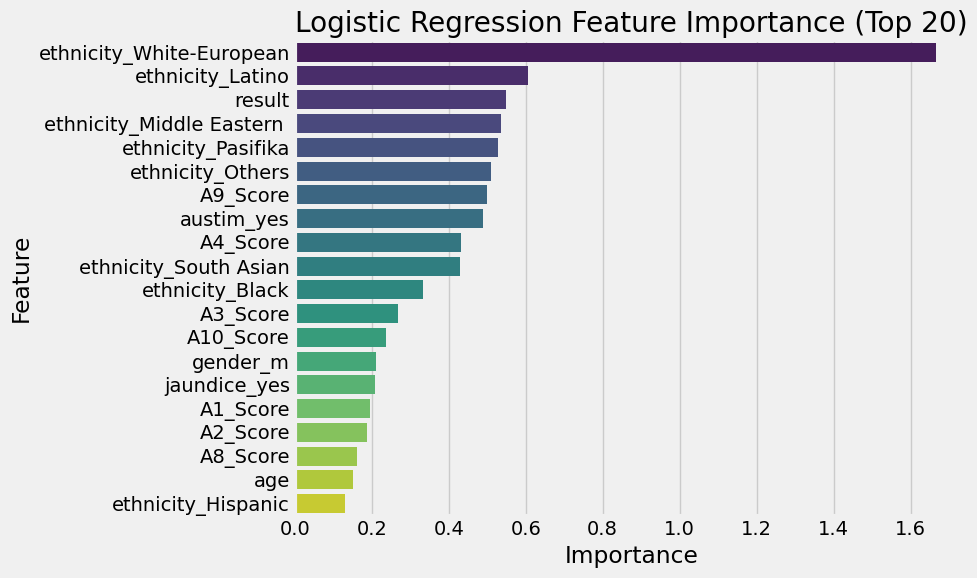

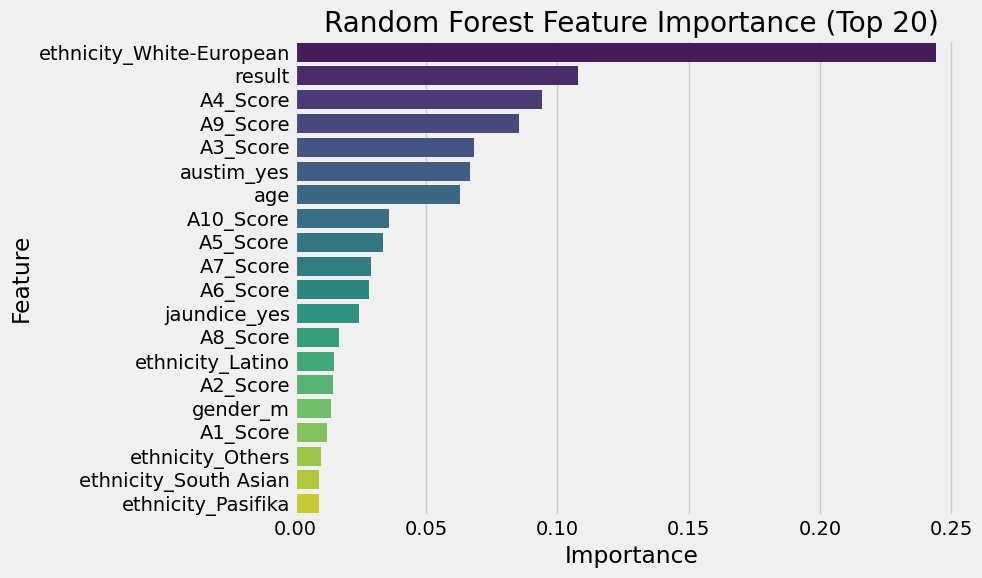

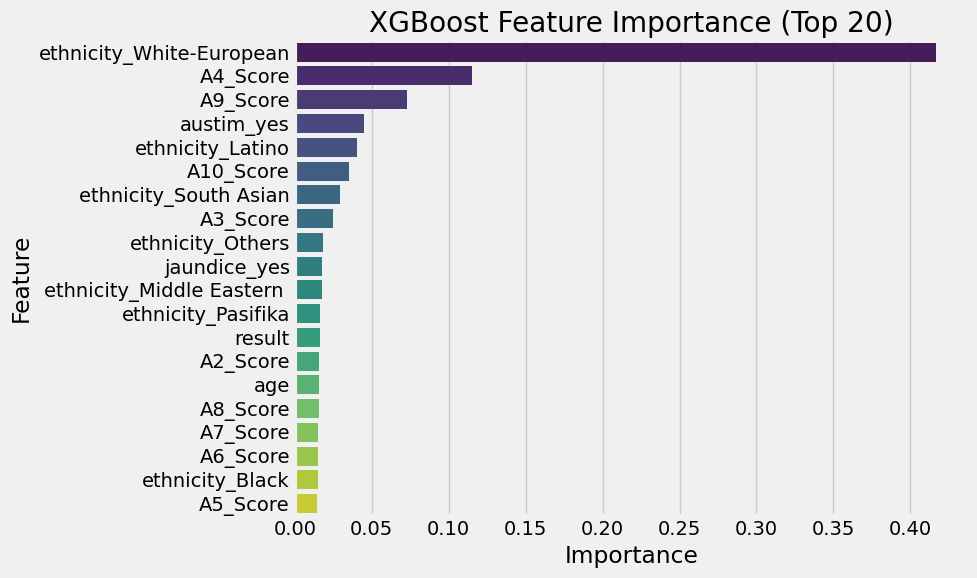

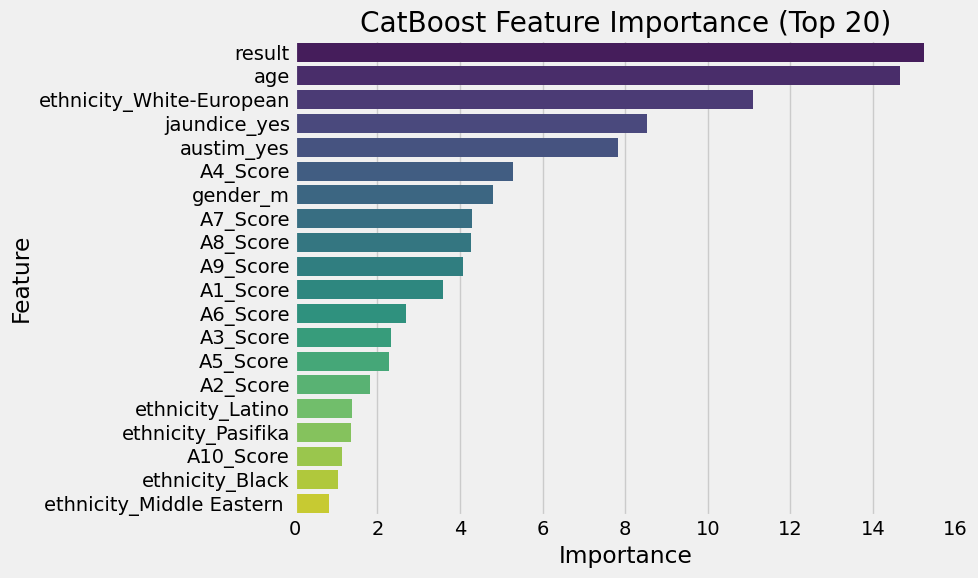


Final results comparison:
                     accuracy   roc_auc    pr_auc        f1       mcc
Logistic Regression  0.769531  0.846191  0.617168  0.578313  0.462723
Random Forest        0.789062  0.859131  0.625669  0.615385  0.510941
XGBoost              0.714844  0.834961  0.549674  0.527778  0.396928
CatBoost             0.761719  0.837891  0.539036  0.586667  0.472300


<Figure size 1200x800 with 0 Axes>

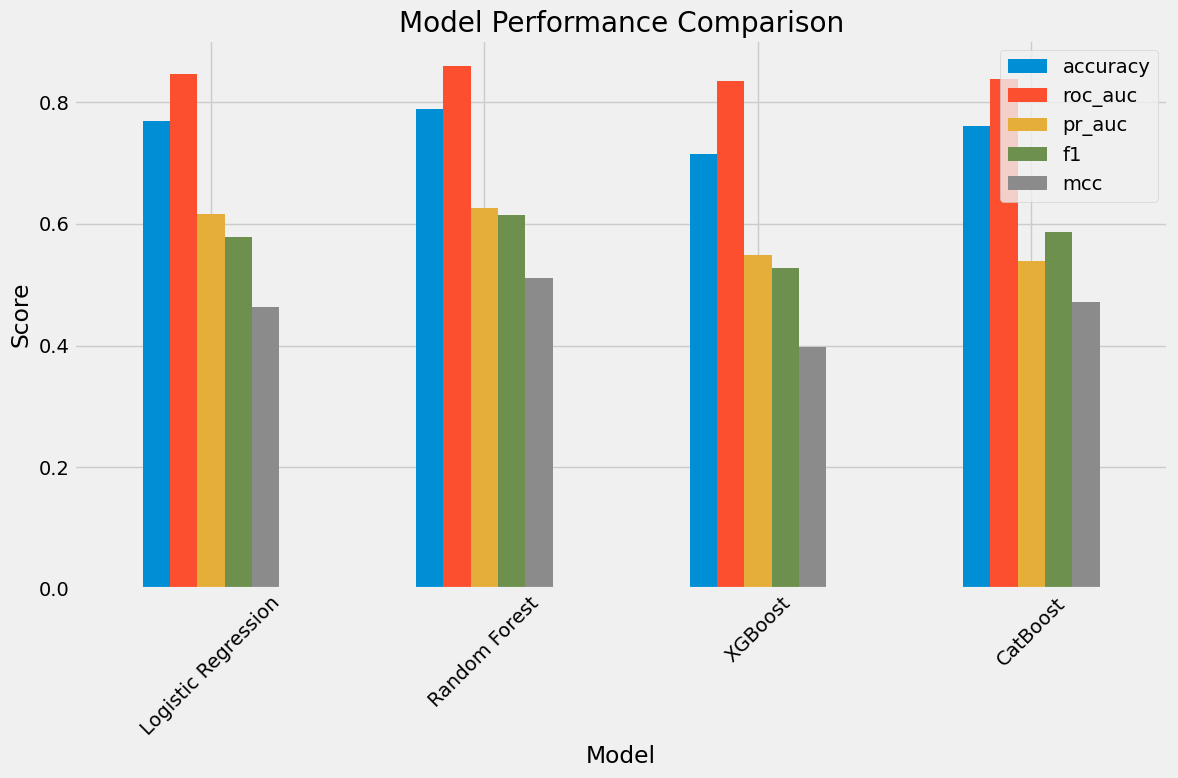

In [535]:
# Feature importance plots
for name, model in trained_models.items():
    importance = get_feature_importance(model, name)
    if importance is not None:
        plt.figure(figsize=(10, 6))
        feature_names = X_train.columns
        feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)
        sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')
        plt.title(f"{name} Feature Importance (Top 20)")
        plt.tight_layout()
        plt.show()

# Display final results comparison
results_df = pd.DataFrame(results).T
print("\nFinal results comparison:")
print(results_df)

# Visualize results comparison
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Neural Net Test

Epoch 1/250
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - auc_4: 0.3698 - loss: 8.1746 - val_accuracy: 0.0000e+00 - val_auc_4: 0.8883 - val_loss: 4.3269 - learning_rate: 0.0010
Epoch 2/250
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - auc_4: 0.8854 - loss: 3.4276 - val_accuracy: 0.0000e+00 - val_auc_4: 0.9217 - val_loss: 1.4251 - learning_rate: 0.0010
Epoch 3/250
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - auc_4: 0.8913 - loss: 1.0903 - val_accuracy: 0.0000e+00 - val_auc_4: 0.9143 - val_loss: 0.5847 - learning_rate: 0.0010
Epoch 4/250
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - auc_4: 0.8617 - loss: 0.4957 - val_accuracy: 0.0000e+00 - val_auc_4: 0.9200 - val_loss: 0.4059 - learning_rate: 0.0010
Epoch 5/250
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - auc_4: 0.9121 - loss: 0.3774 - val_accuracy: 0.0000e+00 - val_auc_4: 0.9164 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 6/250
120

<Axes: >

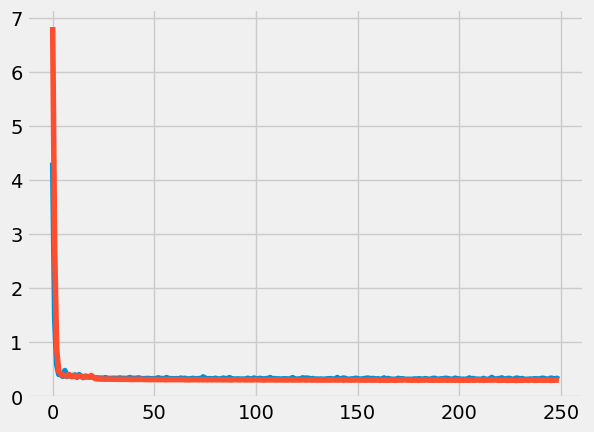

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

eth_label = train.loc[:,['ethnicity','Class/ASD']]
mapper = {
    '?' : 'others',
    'Others' : 'others'
}
eth_label['ethnicity'] = eth_label['ethnicity'].map(lambda x : mapper[x] if x in mapper else x)
eth_label = (eth_label[eth_label['Class/ASD'] == 1]['ethnicity'].value_counts() / eth_label[eth_label['Class/ASD'] == 0]['ethnicity'].value_counts() * eth_label['ethnicity'].value_counts()).sort_values(ascending=False)
eth_label = eth_label.map(lambda x : 0 if np.isnan(x) else x)
eth_label = dict((eth_label - min(eth_label))/(max(eth_label) - min(eth_label)))

def preprocess(data : pd.DataFrame):
    data_temp = data.copy()
    data_temp['gender'] = data_temp['gender'].map(lambda x : 1 if x == 'm' else 0)
    data_temp['jaundice'] = data_temp['jaundice'].map(lambda x : 1 if x == 'yes' else 0)
    data_temp['austim'] = data_temp['austim'].map(lambda x : 1 if x == 'yes' else 0)
    data_temp['ethnicity'] = data_temp['ethnicity'].map(lambda x : 'others' if (x == 'Others' or x == '?') else x)
    data_temp['ethnicity'] = data_temp['ethnicity'].map(eth_label)
    data_temp['age'] = (data_temp['age'] - min(data_temp['age']))/(max(data_temp['age']) - min(data_temp['age']))
    data_temp['result'] = (data_temp['result'] - min(data_temp['result']))/(max(data_temp['result']) - min(data_temp['result']))
    return data_temp

data_train_preprocess = preprocess(train)

x_train,x_test,y_train,y_test = train_test_split(data_train_preprocess.drop('Class/ASD',axis=1),data_train_preprocess['Class/ASD'])


x_train_neural,y_train_neural = (x_train,y_train)



model = tf.keras.Sequential(
    [
        tf.keras.Input(shape = (x_train_neural.shape[1],)),
        tf.keras.layers.Dense(32, activation="relu", name="layer1",kernel_regularizer = tf.keras.regularizers.L1(l1=0.1),),
        tf.keras.layers.Dense(32, activation="relu", name="layer2"),
        tf.keras.layers.Dense(32, activation="relu", name="layer3"),
        tf.keras.layers.Dense(32, activation="relu", name="layer4"),
        tf.keras.layers.Dense(32, activation="relu", name="layer5"),
        tf.keras.layers.Dense(1, activation = 'sigmoid',name="output")
    ]
)

model(x_train_neural.values[0:1])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),tf.keras.metrics.AUC()],
)

callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=5,
        verbose=1,
        min_lr=0.0001,
    )
]

history = model.fit(
    x_train_neural,
    y_train_neural,
    batch_size=5,
    epochs=250,
    callbacks= callbacks,
    validation_data=(x_test, y_test),
)

sns.lineplot(x = [x for x in range(0,len(history.history['val_loss']))],y= history.history['val_loss'])
sns.lineplot(x = [x for x in range(0,len(history.history['loss']))],y= history.history['loss'])


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy Score: 0.7859
ROC-AUC Score: 0.9162
PR-AUC Score (Average Precision): 0.6805


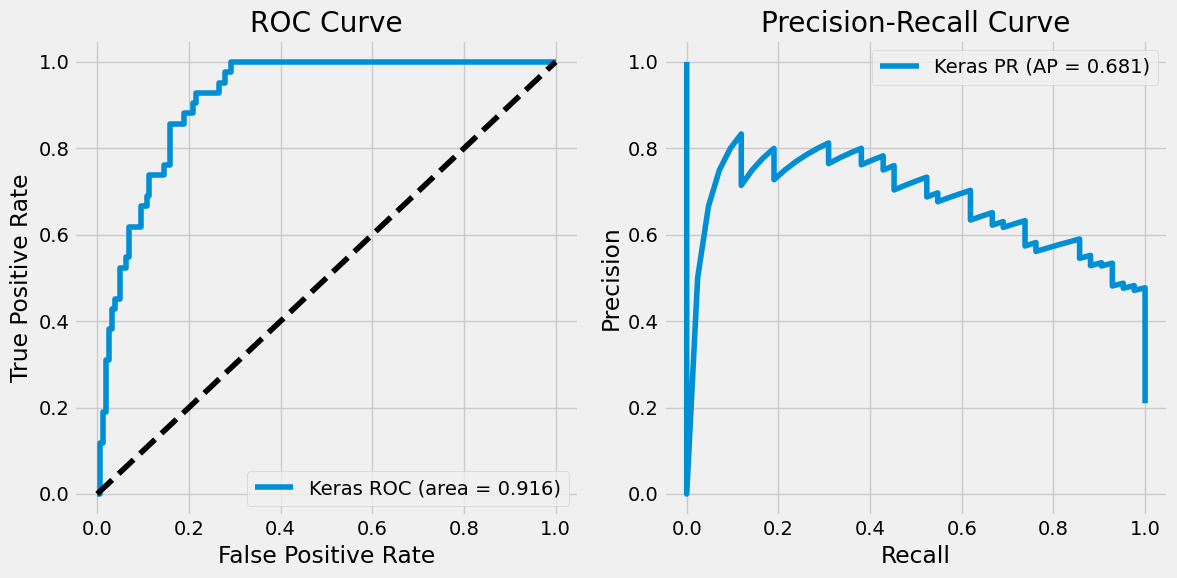

F1 Score: 0.6588
Matthews Correlation Coefficient (MCC): 0.5668


In [ ]:
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score, matthews_corrcoef, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

out_probs = model.predict(x_test) # These are probabilities

out_binary = (out_probs > 0.5).astype(int)

# 0. Accuracy
acc = balanced_accuracy_score(y_test, out_binary)
print(f"Accuracy Score: {acc:.4f}")

# 1. ROC Curve and ROC-AUC Score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, out_probs)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"ROC-AUC Score: {auc_keras:.4f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_keras, tpr_keras, label='Keras ROC (area = {:.3f})'.format(auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

# 2. Precision-Recall Curve and PR-AUC (Average Precision)
precision, recall, thresholds_pr = precision_recall_curve(y_test, out_probs)
pr_auc_score = average_precision_score(y_test, out_probs) # This is a common way to get PR-AUC

print(f"PR-AUC Score (Average Precision): {pr_auc_score:.4f}")


plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Keras PR (AP = {:.3f})'.format(pr_auc_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 3. F1-Score
f1 = f1_score(y_test, out_binary)
print(f"F1 Score: {f1:.4f}")

# 4. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, out_binary)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Phase 3: Model Explainability & Fairness

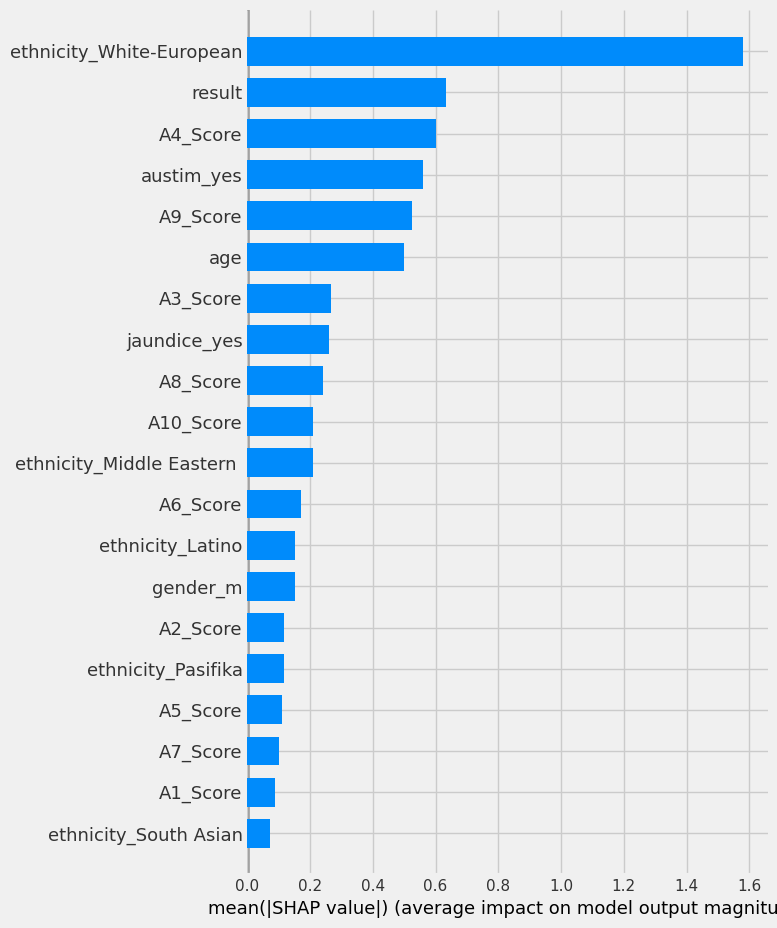

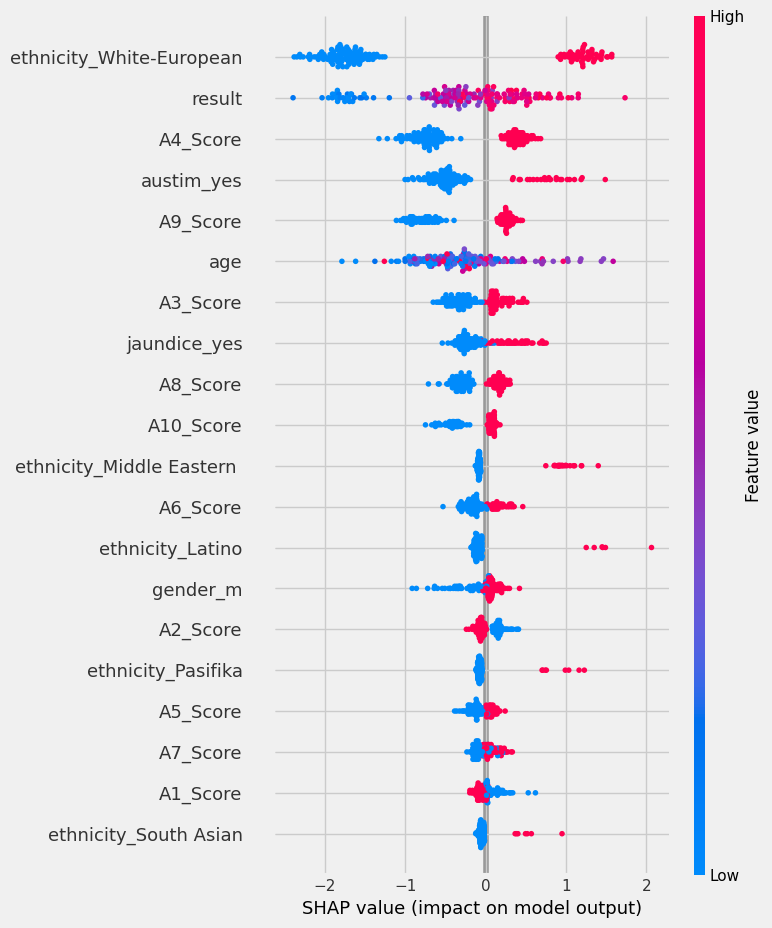

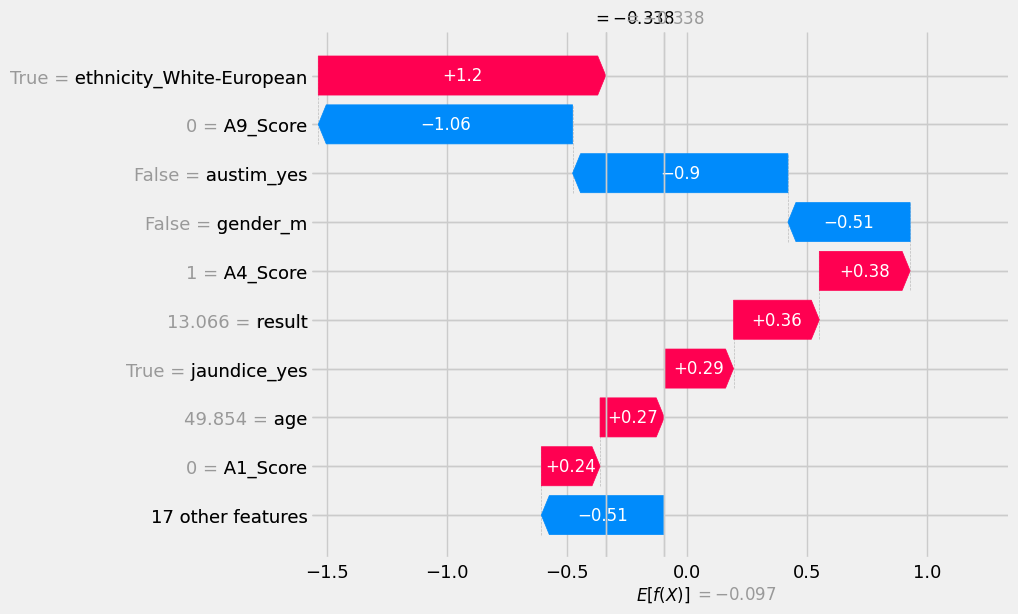

In [ ]:
import shap

# Let's choose the best performing model based on your results
# Assuming XGBoost performed well based on your code
best_model = trained_models["XGBoost"]

# Create SHAP explainer
explainer = shap.Explainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed SHAP plot for feature dependencies
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction (e.g., first test instance)
shap.plots.force(shap_values[0])

# Create a waterfall plot for an individual prediction
shap.plots.waterfall(shap_values[0])

In [ ]:
# Check the shapes of your test data
print("X_test shape:", X_test.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)

# Make sure you're using the same version of the test data
# The error suggests you might be using X_test_scaled for one part
# and X_test for another, or there's some other mismatch

# Try this instead:
result = permutation_importance(
    best_model, X_test_scaled, y_test, 
    n_repeats=10, random_state=17, 
    scoring='roc_auc'
)

# And when plotting, make sure to use the correct column names
sorted_idx = result.importances_mean.argsort()[::-1]
feature_names = X_test.columns  # Get the feature names from the original DataFrame

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False,
            labels=[feature_names[i] for i in sorted_idx])
plt.title("Permutation Importance (ROC AUC)")
plt.tight_layout()
plt.show()

# For the DataFrame display
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Permutation_Importance': result.importances_mean
}).sort_values('Permutation_Importance', ascending=False)

display(perm_importance_df.head(10))


X_test shape: (160, 26)
X_test_scaled shape: (160, 26)
y_test shape: (200,)


ValueError: Found input variables with inconsistent numbers of samples: [200, 160]

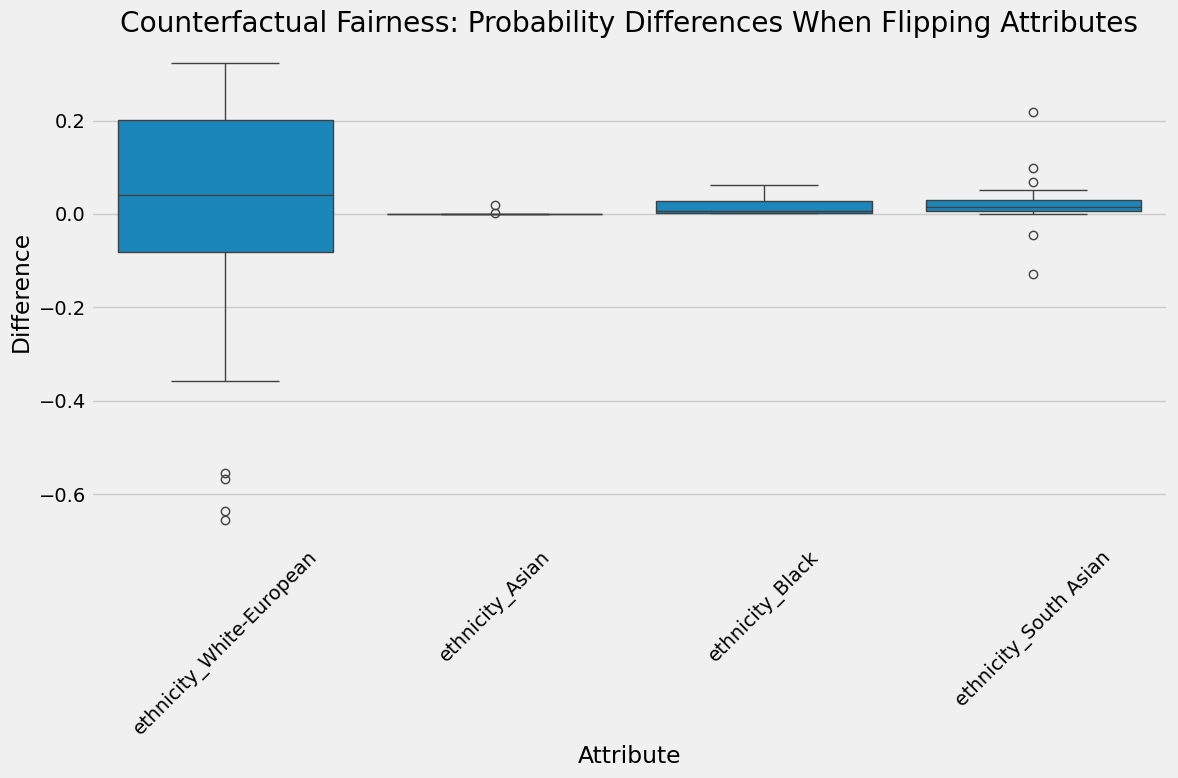

,count,mean,std,min,25%,50%,75%,max
Attribute,,,,,,,,
ethnicity_Asian,20.0,0.001240,0.004175,-0.000323,0.000000,0.000000,0.000617,0.018788
ethnicity_Black,20.0,0.017487,0.018840,0.001050,0.001868,0.006914,0.028749,0.062987
ethnicity_South Asian,20.0,0.022583,0.063519,-0.127585,0.005619,0.014281,0.029103,0.217616
ethnicity_White-European,20.0,-0.043615,0.321511,-0.654624,-0.080343,0.041206,0.201508,0.322714


In [502]:
# We need to recreate the preprocessing for new instances
sensitive_attributes = ['gender_Male', 'ethnicity_White-European', 'ethnicity_Asian', 
                        'ethnicity_Middle Eastern', 'ethnicity_Black', 'ethnicity_South Asian']

# Function to create counterfactual instances
def create_counterfactual(instance, attribute_to_flip):
    """Create counterfactual by flipping the value of a sensitive attribute"""
    counterfactual = instance.copy()
    counterfactual[attribute_to_flip] = 1 - counterfactual[attribute_to_flip]
    return counterfactual

# Apply counterfactual test on sample instances
def counterfactual_test(model, instances, sensitive_attrs, needs_scaling=False):
    results = []
    for idx, instance in instances.iterrows():
        base_pred_prob = model.predict_proba(instance.values.reshape(1, -1))[0][1]
        
        for attr in sensitive_attrs:
            if attr in instance.index:  # Check if attribute exists for this instance
                cf_instance = create_counterfactual(instance, attr)
                cf_pred_prob = model.predict_proba(cf_instance.values.reshape(1, -1))[0][1]
                diff = cf_pred_prob - base_pred_prob
                results.append({
                    'Instance': idx,
                    'Attribute': attr,
                    'Original_Prob': base_pred_prob,
                    'Counterfactual_Prob': cf_pred_prob,
                    'Difference': diff
                })
    
    return pd.DataFrame(results)

# Select a sample of test instances
sample_instances = X_test.sample(n=20, random_state=42)

# Prepare data for the model (scaling if needed)
if model_configs["XGBoost"]["needs_scaling"]:
    sample_instances_scaled = scaler.transform(sample_instances)
else:
    sample_instances_scaled = sample_instances

# Run counterfactual test
cf_results = counterfactual_test(best_model, sample_instances, sensitive_attributes)

# Visualize differences
plt.figure(figsize=(12, 8))
sns.boxplot(x='Attribute', y='Difference', data=cf_results)
plt.title('Counterfactual Fairness: Probability Differences When Flipping Attributes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary statistics of differences by attribute
display(cf_results.groupby('Attribute')['Difference'].describe())

In [503]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import MetricFrame

# Define sensitive features from original dataset (before one-hot encoding)
# We need to reconstruct these from our encoded features
sensitive_features_dict = {}

# Reconstruct gender from one-hot encoded features
sensitive_features_dict['gender'] = np.where(X_test['gender_Male'] == 1, 'Male', 'Female')

# Check if ethnicity columns exist and reconstruct ethnicity
ethnicity_cols = [col for col in X_test.columns if col.startswith('ethnicity_')]
if ethnicity_cols:
    ethnicities = ['Other'] * len(X_test)  # Default value
    for col in ethnicity_cols:
        ethnicity_name = col.replace('ethnicity_', '')
        ethnicities = [ethnicity_name if val == 1 else curr for val, curr in zip(X_test[col], ethnicities)]
    sensitive_features_dict['ethnicity'] = ethnicities

# Get model predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Create fairness metrics for each sensitive attribute
for attr_name, attr_values in sensitive_features_dict.items():
    print(f"\nFairness metrics for {attr_name}:")
    
    # MetricFrame evaluates metrics for different subgroups
    mf = MetricFrame(
        metrics={
            'accuracy': balanced_accuracy_score,
            'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
            'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=0),
            'false_positive_rate': lambda y_true, y_pred: 
                np.sum((y_pred == 1) & (y_true == 0)) / np.sum(y_true == 0) if np.sum(y_true == 0) > 0 else 0
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=attr_values
    )
    
    # Display metrics by group
    display(mf.by_group)
    
    # Display disparity metrics
    display(mf.group_min())
    display(mf.group_max())
    display(mf.difference())
    
    # Calculate demographic parity and equalized odds
    dp_diff = demographic_parity_difference(
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=attr_values
    )
    
    eo_diff = equalized_odds_difference(
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=attr_values
    )
    
    print(f"Demographic Parity Difference: {dp_diff:.4f}")
    print(f"Equalized Odds Difference: {eo_diff:.4f}")
    
    # Visualize disparities
    plt.figure(figsize=(10, 6))
    sns.heatmap(mf.by_group.T, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f'Metrics by {attr_name} group')
    plt.tight_layout()
    plt.show()

KeyError: 'gender_Male'

In [ ]:
# Summarize findings and create recommendations
fairness_issues = []
if dp_diff > 0.1:  # Example threshold
    fairness_issues.append(f"High demographic parity difference ({dp_diff:.4f}) for {attr_name}")
if eo_diff > 0.1:  # Example threshold
    fairness_issues.append(f"High equalized odds difference ({eo_diff:.4f}) for {attr_name}")

# Check for large counterfactual differences
for attr, group in cf_results.groupby('Attribute'):
    mean_diff = group['Difference'].abs().mean()
    if mean_diff > 0.1:  # Example threshold
        fairness_issues.append(f"Large counterfactual differences ({mean_diff:.4f}) for {attr}")

print("\nPotential fairness issues identified:")
for issue in fairness_issues:
    print(f"- {issue}")

print("\nRecommendations:")
if fairness_issues:
    print("1. Consider applying fairness constraints during model training")
    print("2. Explore model-agnostic post-processing methods to equalize outcomes")
    print("3. Review and potentially rebalance training data for sensitive groups")
else:
    print("No significant fairness issues detected")

# Create a comprehensive dashboard with all key insights
plt.figure(figsize=(15, 10))

# 1. SHAP summary in top-left
plt.subplot(2, 2, 1)
# Add code to display SHAP summary (simplified version)

# 2. Permutation importance in top-right
plt.subplot(2, 2, 2)
# Add code to display permutation importance

# 3. Counterfactual fairness in bottom-left
plt.subplot(2, 2, 3)
# Add code to display counterfactual fairness

# 4. Demographic parity in bottom-right
plt.subplot(2, 2, 4)
# Add code to display demographic parity

plt.tight_layout()
plt.savefig('model_explainability_fairness_dashboard.png')
plt.show()

In [473]:
# ============================================================================
# MODEL EXPLAINABILITY AND FAIRNESS ASSESSMENT
# ============================================================================
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MODEL EXPLAINABILITY AND FAIRNESS ASSESSMENT")
print("="*80)

# Let's identify sensitive attributes in our dataset
sensitive_attributes = [col for col in X_test.columns if col.startswith(('gender_', 'ethnicity_'))]
print(f"Identified sensitive attributes: {sensitive_attributes}")

# Create a mapping back to original features for better interpretability
feature_mapping = {}
for col in X_test.columns:
    if isinstance(col, str) and '_' in col:
        base, value = col.split('_', 1)
        if base in ['gender', 'ethnicity', 'jaundice', 'austim']:
            feature_mapping[col] = f"{base}={value}"
    else:
        feature_mapping[col] = col

# Choose the best performing model for detailed analysis
best_model_name = results_df['roc_auc'].idxmax()
best_model = trained_models[best_model_name]
print(f"Using {best_model_name} for detailed explainability and fairness analysis (highest ROC-AUC)")

# ============================================================================
# 1. SHAP VALUES ANALYSIS
# ============================================================================
print("\n1. SHAP VALUES ANALYSIS")
print("-"*80)

# Function to get the right data format for the model
def get_model_data(model_name, X_data):
    if model_configs[model_name]["needs_scaling"]:
        return scaler.transform(X_data)
    return X_data

# Get the appropriate test data format
X_test_for_model = get_model_data(best_model_name, X_test)

# Convert feature names to a list to avoid Index issues
feature_names_list = list(X_test.columns)
feature_display_names = [feature_mapping.get(name, name) for name in feature_names_list]

try:
    # Create SHAP explainer based on model type
    if best_model_name in ["Random Forest", "XGBoost"]:
        explainer = shap.TreeExplainer(best_model)
        # Use a smaller sample for faster computation
        sample_size = min(100, X_test_for_model.shape[0])
        sample_indices = np.random.choice(X_test_for_model.shape[0], sample_size, replace=False)
        X_sample = X_test_for_model[sample_indices] if isinstance(X_test_for_model, np.ndarray) else X_test_for_model.iloc[sample_indices]
        
        shap_values = explainer.shap_values(X_sample)
        
        # For XGBoost with binary classification, we might need to handle the output differently
        if best_model_name == "XGBoost" and isinstance(shap_values, list):
            shap_values = shap_values[1]  # Get the positive class
            
    elif best_model_name == "CatBoost":
        explainer = shap.TreeExplainer(best_model)
        # Use a smaller sample for faster computation
        sample_size = min(100, X_test_for_model.shape[0])
        sample_indices = np.random.choice(X_test_for_model.shape[0], sample_size, replace=False)
        X_sample = X_test_for_model[sample_indices] if isinstance(X_test_for_model, np.ndarray) else X_test_for_model.iloc[sample_indices]
        
        shap_values = explainer.shap_values(X_sample)
    else:  # Logistic Regression or other models
        # Sample a subset of data for KernelExplainer to make it faster
        sample_size = min(50, X_test_for_model.shape[0])
        sample_indices = np.random.choice(X_test_for_model.shape[0], sample_size, replace=False)
        X_sample = X_test_for_model[sample_indices] if isinstance(X_test_for_model, np.ndarray) else X_test_for_model.iloc[sample_indices]
        
        background_data = shap.sample(X_test_for_model, min(50, X_test_for_model.shape[0]))
        explainer = shap.KernelExplainer(
            lambda x: best_model.predict_proba(x)[:, 1] if hasattr(best_model, "predict_proba") else best_model.predict(x), 
            background_data
        )
        shap_values = explainer.shap_values(X_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Get the positive class

    # 1.1 Summary Plot - Shows feature importance and impact direction
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_display_names, show=False)
    plt.title(f"SHAP Feature Importance for {best_model_name}")
    plt.tight_layout()
    plt.show()

    # 1.2 Calculate mean absolute SHAP values for feature importance
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        'Feature': feature_display_names,
        'Importance': mean_abs_shap
    }).sort_values('Importance', ascending=False)
    
    # Display top 10 features by SHAP importance
    print("\nTop 10 Features by SHAP Importance:")
    display(feature_importance.head(10))
    
    # Plot top 10 features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title(f"Top 10 Features by SHAP Importance - {best_model_name}")
    plt.tight_layout()
    plt.show()
    
    # 1.3 Dependence plots for top 3 features
    top_features = feature_importance.head(3)['Feature'].values
    for i, feature in enumerate(top_features):
        # Find the index of this feature in our feature list
        feature_idx = feature_display_names.index(feature)
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx, shap_values, X_sample, 
            feature_names=feature_display_names, 
            show=False
        )
        plt.title(f"SHAP Dependence Plot for {feature}")
        plt.tight_layout()
        plt.show()

    # 1.4 Force plot for a sample prediction
    plt.figure(figsize=(20, 3))
    sample_idx = np.random.choice(len(X_sample))
    expected_value = explainer.expected_value
    if isinstance(expected_value, list):
        expected_value = expected_value[1]  # For binary classification

    shap.initjs()
    display(shap.force_plot(expected_value, 
                           shap_values[sample_idx:sample_idx+1], 
                           X_sample[sample_idx:sample_idx+1],
                           feature_names=feature_display_names))

except Exception as e:
    print(f"Error in SHAP analysis: {str(e)}")
    print("Skipping SHAP analysis and moving to permutation importance.")

# ============================================================================
# 2. PERMUTATION IMPORTANCE
# ============================================================================
print("\n2. PERMUTATION IMPORTANCE")
print("-"*80)

try:
    # Calculate permutation importance
    result = permutation_importance(
        best_model, X_test_for_model, y_test, 
        n_repeats=10, random_state=42, n_jobs=-1
    )

    # Sort features by importance
    sorted_idx = result.importances_mean.argsort()[::-1]
    sorted_features = [feature_names_list[i] for i in sorted_idx]
    sorted_display_names = [feature_mapping.get(name, name) for name in sorted_features]

    # Plot permutation importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
    plt.yticks(range(len(sorted_idx)), sorted_display_names)
    plt.xlabel('Permutation Importance')
    plt.title(f'Permutation Feature Importance for {best_model_name}')
    plt.tight_layout()
    plt.show()

    # Create a dataframe for permutation importance
    perm_importance_df = pd.DataFrame({
        'Feature': sorted_display_names,
        'Importance': result.importances_mean[sorted_idx]
    })
    
    print("\nTop 10 Features by Permutation Importance:")
    display(perm_importance_df.head(10))

    # If SHAP analysis was successful, compare with SHAP importance
    if 'feature_importance' in locals():
        # Create a comparison dataframe for the top 10 features
        top_perm_features = set(perm_importance_df.head(10)['Feature'])
        top_shap_features = set(feature_importance.head(10)['Feature'])
        common_features = top_perm_features.intersection(top_shap_features)
        
        print(f"\nFeatures in both top 10 lists: {len(common_features)} out of 10")
        print(f"Common features: {', '.join(common_features)}")
        
        # Create a merged dataframe for visualization
        merged_df = pd.merge(
            perm_importance_df.head(10), 
            feature_importance.head(10), 
            on='Feature', 
            how='outer',
            suffixes=('_Perm', '_SHAP')
        ).fillna(0)
        
        # Plot comparison
        plt.figure(figsize=(14, 8))
        merged_df = merged_df.sort_values('Importance_Perm', ascending=False)
        
        # Normalize importances for better comparison
        merged_df['Importance_Perm_Norm'] = merged_df['Importance_Perm'] / merged_df['Importance_Perm'].max()
        merged_df['Importance_SHAP_Norm'] = merged_df['Importance_SHAP'] / merged_df['Importance_SHAP'].max()
        
        # Plot
        x = np.arange(len(merged_df))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.bar(x - width/2, merged_df['Importance_Perm_Norm'], width, label='Permutation')
        ax.bar(x + width/2, merged_df['Importance_SHAP_Norm'], width, label='SHAP')
        
        ax.set_xticks(x)
        ax.set_xticklabels(merged_df['Feature'], rotation=45, ha='right')
        ax.legend()
        ax.set_title('Normalized Feature Importance: Permutation vs SHAP')
        ax.set_ylabel('Normalized Importance')
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error in permutation importance analysis: {str(e)}")
    print("Skipping permutation importance analysis.")

# ============================================================================
# 3. COUNTERFACTUAL FAIRNESS TEST
# ============================================================================
print("\n3. COUNTERFACTUAL FAIRNESS TEST")
print("-"*80)

def counterfactual_fairness_test(model, X, model_name, sensitive_feature, feature_value=1, alternative_value=0):
    """
    Test how predictions change when only the sensitive feature is modified
    """
    # Check if the sensitive feature exists in the dataset
    if sensitive_feature not in X.columns:
        print(f"Warning: {sensitive_feature} not found in dataset. Skipping test.")
        return None
    
    # Create copies with the sensitive feature changed
    X_with_feature = X.copy()
    X_without_feature = X.copy()
    
    # Set the feature values
    X_with_feature[sensitive_feature] = feature_value
    X_without_feature[sensitive_feature] = alternative_value
    
    # Get the appropriate data format for the model
    X_with_feature_model = get_model_data(model_name, X_with_feature)
    X_without_feature_model = get_model_data(model_name, X_without_feature)
    
    # Get predictions for both versions
    if hasattr(model, "predict_proba"):
        with_feature_preds = model.predict_proba(X_with_feature_model)[:, 1]
        without_feature_preds = model.predict_proba(X_without_feature_model)[:, 1]
    else:
        with_feature_preds = model.predict(X_with_feature_model)
        without_feature_preds = model.predict(X_without_feature_model)
    
    # Calculate difference statistics
    diff = with_feature_preds - without_feature_preds
    
    return {
        'mean_diff': diff.mean(),
        'abs_mean_diff': np.abs(diff).mean(),
        'max_diff': np.max(np.abs(diff)),
        'std_diff': diff.std(),
        'with_feature_mean': with_feature_preds.mean(),
        'without_feature_mean': without_feature_preds.mean(),
        'diffs': diff
    }

try:
    # Check if gender_m exists in the dataset
    if 'gender_m' in X_test.columns:
        # Test counterfactual fairness for gender
        gender_fairness = counterfactual_fairness_test(
            best_model, X_test, best_model_name, 
            sensitive_feature='gender_m'
        )

        print(f"Counterfactual Fairness Test for Gender (male vs. female):")
        print(f"  Mean prediction difference: {gender_fairness['mean_diff']:.4f}")
        print(f"  Mean absolute difference: {gender_fairness['abs_mean_diff']:.4f}")
        print(f"  Maximum difference: {gender_fairness['max_diff']:.4f}")
        print(f"  Standard deviation of differences: {gender_fairness['std_diff']:.4f}")
        print(f"  Average prediction for males: {gender_fairness['with_feature_mean']:.4f}")
        print(f"  Average prediction for females: {gender_fairness['without_feature_mean']:.4f}")

        # Visualize the distribution of prediction differences
        plt.figure(figsize=(10, 6))
        sns.histplot(gender_fairness['diffs'], kde=True)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('Distribution of Prediction Differences: Male vs Female')
        plt.xlabel('Prediction Difference (Male - Female)')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: 'gender_m' column not found in the dataset. Skipping gender fairness test.")

    # Test counterfactual fairness for ethnicity groups
    ethnicity_results = {}
    ethnicity_features = [col for col in X_test.columns if col.startswith('ethnicity_')]

    for feature in ethnicity_features:
        if feature == 'ethnicity_nan':  # Skip missing values
            continue
        ethnicity_name = feature.split('_')[1]
        result = counterfactual_fairness_test(
            best_model, X_test, best_model_name, 
            sensitive_feature=feature
        )
        if result is not None:
            ethnicity_results[ethnicity_name] = result

    # Create a summary dataframe for ethnicity fairness if we have results
    if ethnicity_results:
        ethnicity_df = pd.DataFrame({
            'Ethnicity': list(ethnicity_results.keys()),
            'Mean Diff': [res['mean_diff'] for res in ethnicity_results.values()],
            'Abs Mean Diff': [res['abs_mean_diff'] for res in ethnicity_results.values()],
            'Max Diff': [res['max_diff'] for res in ethnicity_results.values()],
            'Avg Pred With': [res['with_feature_mean'] for res in ethnicity_results.values()],
            'Avg Pred Without': [res['without_feature_mean'] for res in ethnicity_results.values()]
        })

        print("\nCounterfactual Fairness Test for Ethnicity Groups:")
        display(ethnicity_df.sort_values('Abs Mean Diff', ascending=False))

        # Visualize ethnicity fairness results
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Ethnicity', y='Mean Diff', data=ethnicity_df)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Mean Prediction Difference by Ethnicity')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No ethnicity features found or all tests were skipped.")

except Exception as e:
    print(f"Error in counterfactual fairness test: {str(e)}")
    print("Skipping counterfactual fairness test.")

# ============================================================================
# 4. FAIRNESS METRICS DASHBOARD (FAIRLEARN)
# ============================================================================
print("\n4. FAIRNESS METRICS DASHBOARD")
print("-"*80)

try:
    # Prepare data for fairness analysis
    # We need to map back the one-hot encoded features to their original categories
    # First, let's check if gender_m exists in the dataset
    if 'gender_m' in X_test.columns:
        gender_map = X_test['gender_m'].map({1: 'Male', 0: 'Female'})
    else:
        gender_map = pd.Series('Unknown', index=X_test.index)
        print("Warning: 'gender_m' column not found. Using 'Unknown' for all gender values.")

    # For ethnicity, we need to determine which column has the value 1 for each row
    ethnicity_cols = [col for col in X_test.columns if col.startswith('ethnicity_')]
    ethnicity_map = pd.Series('Unknown', index=X_test.index)

    if ethnicity_cols:
        for idx in X_test.index:
            for col in ethnicity_cols:
                if X_test.loc[idx, col] == 1:
                    ethnicity_name = col.split('_')[1]
                    ethnicity_map[idx] = ethnicity_name
                    break
    else:
        print("Warning: No ethnicity columns found. Using 'Unknown' for all ethnicity values.")

    # Get model predictions
    y_pred = best_model.predict(X_test_for_model)
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_for_model)[:, 1]
    else:
        y_prob = y_pred

    # Define metrics for fairness assessment
    fairness_metrics = {
        'accuracy': lambda y_true, y_pred: np.mean(y_true == y_pred),
        'selection_rate': selection_rate,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'precision': lambda y_true, y_pred: np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_pred == 1) if np.sum(y_pred == 1) > 0 else 0,
        'recall': lambda y_true, y_pred: np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
    }

    # 4.1 Gender Fairness Analysis
    gender_metric_frame = MetricFrame(
        metrics=fairness_metrics,
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=gender_map
    )

    print("\nFairness Metrics by Gender:")
    display(gender_metric_frame.by_group)
    print("\nDisparity Ratios (min/max):")
    display(gender_metric_frame.ratio(method='between_groups'))

    # Visualize gender fairness metrics
    plt.figure(figsize=(14, 8))
    gender_metrics_df = gender_metric_frame.by_group.reset_index()
    gender_metrics_df = pd.melt(gender_metrics_df, id_vars=['sensitive_feature'], 
                               var_name='Metric', value_name='Value')

    sns.barplot(x='Metric', y='Value', hue='sensitive_feature', data=gender_metrics_df)
    plt.title('Fairness Metrics by Gender')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()

    # 4.2 Ethnicity Fairness Analysis
    # Filter to only include ethnicities with sufficient samples
    ethnicity_counts = ethnicity_map.value_counts()
    valid_ethnicities = ethnicity_counts[ethnicity_counts >= 10].index.tolist()

    if valid_ethnicities:
        filtered_ethnicity_map = ethnicity_map[ethnicity_map.isin(valid_ethnicities)]
        filtered_indices = filtered_ethnicity_map.index

        if len(filtered_indices) > 0:
            # Create a boolean mask for the filtered indices
            mask = np.array([i in filtered_indices for i in y_test.index])
            
            ethnicity_metric_frame = MetricFrame(
                metrics=fairness_metrics,
                y_true=y_test.loc[filtered_indices],
                y_pred=y_pred[mask],
                sensitive_features=filtered_ethnicity_map
            )

            print("\nFairness Metrics by Ethnicity (groups with 10+ samples):")
            display(ethnicity_metric_frame.by_group)
            print("\nDisparity Ratios (min/max):")
            display(ethnicity_metric_frame.ratio(method='between_groups'))

            # Visualize ethnicity fairness metrics
            plt.figure(figsize=(16, 10))
            ethnicity_metrics_df = ethnicity_metric_frame.by_group.reset_index()
            ethnicity_metrics_df = pd.melt(ethnicity_metrics_df, id_vars=['sensitive_feature'], 
                                          var_name='Metric', value_name='Value')

            # Create a grouped bar chart
            g = sns.catplot(
                data=ethnicity_metrics_df, kind="bar",
                x="Metric", y="Value", hue="sensitive_feature",
                height=6, aspect=2, palette="viridis"
            )
            g.set_xticklabels(rotation=45)
            plt.title('Fairness Metrics by Ethnicity')
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.show()
        else:
            print("No ethnicity groups with 10+ samples found. Skipping ethnicity fairness analysis.")
    else:
        print("No valid ethnicity groups found. Skipping ethnicity fairness analysis.")

    # 4.3 Fairness Summary Dashboard
    print("\nFAIRNESS SUMMARY DASHBOARD")
    print("-"*80)

    # Create a summary of the most important fairness metrics
    fairness_summary = pd.DataFrame({
        'Gender Disparity Ratio': gender_metric_frame.ratio(method='between_groups'),
    })

    # Add ethnicity disparity ratio if available
    if 'ethnicity_metric_frame' in locals():
        fairness_summary['Ethnicity Disparity Ratio'] = ethnicity_metric_frame.ratio(method='between_groups')

    # Add a column indicating potential fairness concerns
    fairness_threshold = 0.8  # 80% rule of thumb
    fairness_summary['Gender Concern'] = fairness_summary['Gender Disparity Ratio'] < fairness_threshold

    if 'Ethnicity Disparity Ratio' in fairness_summary.columns:
        fairness_summary['Ethnicity Concern'] = fairness_summary['Ethnicity Disparity Ratio'] < fairness_threshold

    print("Fairness Summary (Disparity Ratios and Concerns):")
    display(fairness_summary)

    # Visualize the fairness summary
    plt.figure(figsize=(12, 6))
    disparity_columns = [col for col in fairness_summary.columns if 'Disparity' in col]
    sns.heatmap(
        fairness_summary[disparity_columns], 
        annot=True, 
        cmap='RdYlGn', 
        vmin=0, 
        vmax=1,
        linewidths=.5
    )
    plt.title('Fairness Disparity Ratios (Higher is Better)')
    plt.tight_layout()
    plt.show()

    # ============================================================================
    # 5. FAIRNESS RECOMMENDATIONS
    # ============================================================================
    print("\n5. FAIRNESS RECOMMENDATIONS")
    print("-"*80)

    # Identify metrics with potential fairness issues
    gender_concerns = fairness_summary[fairness_summary['Gender Concern']].index.tolist()
    ethnicity_concerns = []
    if 'Ethnicity Concern' in fairness_summary.columns:
        ethnicity_concerns = fairness_summary[fairness_summary['Ethnicity Concern']].index.tolist()

    print("Based on the fairness analysis, here are recommendations to improve model fairness:")

    if gender_concerns:
        print(f"\nGender fairness concerns in: {', '.join(gender_concerns)}")
        print("Recommendations:")
        print("1. Consider resampling training data to ensure balanced representation across genders")
        print("2. Explore model-specific fairness constraints or post-processing techniques")
        print("3. Evaluate if gender should be included as a feature or if it introduces bias")

    if ethnicity_concerns:
        print(f"\nEthnicity fairness concerns in: {', '.join(ethnicity_concerns)}")
        print("Recommendations:")
        print("1. Increase data collection for underrepresented ethnic groups")
        print("2. Apply fairness-aware algorithms that can handle imbalanced group representation")
        print("3. Consider using techniques like adversarial debiasing to reduce ethnicity-based disparities")

    if not gender_concerns and not ethnicity_concerns:
        print("\nNo major fairness concerns detected based on the 80% rule threshold.")
        print("However, continue monitoring model performance across demographic groups as new data becomes available.")

    print("\nGeneral recommendations:")
    print("1. Regularly audit model predictions for fairness across sensitive attributes")
    print("2. Consider collecting additional demographic information to enable more comprehensive fairness analysis")
    print("3. Implement human review for cases where the model's confidence is low or predictions differ significantly across demographic groups")

except Exception as e:
    print(f"Error in fairness metrics dashboard: {str(e)}")
    print("Skipping fairness metrics dashboard.")


MODEL EXPLAINABILITY AND FAIRNESS ASSESSMENT
Identified sensitive attributes: ['gender_m', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic', 'ethnicity_Latino', 'ethnicity_Middle Eastern ', 'ethnicity_Others', 'ethnicity_Pasifika', 'ethnicity_South Asian', 'ethnicity_Turkish', 'ethnicity_White-European', 'ethnicity_others']


KeyError: 'Random Forest'